
# Iowa State Liquor Purchases by Store

## How do we best identify and decide on the location for a new liquor store in Iowa?

Iowa happily provides information down to the transaction for liquor sales to stores accross the state: https://data.iowa.gov

We are going to take a look at this data and see if we can come up with a model that is able to predict total yearly sales by store.  We'll use this to look at to see if we can find the best markets to open up a new shop.

In [1]:
# Start with the simple stuff.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

## Load the data into a DataFrame
df = pd.read_csv('/Users/dale/DSI/Datasets/Iowa/Iowa_Liquor_sales_sample_10pct.csv', na_filter=False)

In [2]:
df.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,11/04/2015,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.0,2.38
1,03/02/2016,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,$13.75,$20.63,2,$41.26,1.5,0.40
2,02/11/2016,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,$12.59,$18.89,24,$453.36,24.0,6.34
3,02/03/2016,2501,AMES,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,$9.50,$14.25,6,$85.50,10.5,2.77
4,08/18/2015,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,$7.20,$10.80,12,$129.60,21.0,5.55


In [3]:
# Let's start with some simple exploratory data analysis.
def eda(dataframe):
    print("missing values \n", dataframe.isnull().sum(), '\n')
    print("dataframe index \n", dataframe.index, '\n')
    print("dataframe types \n", dataframe.dtypes, '\n')
    print("dataframe shape \n", dataframe.shape, '\n')
    print("dataframe describe \n", dataframe.describe(include='all'), '\n')

In [4]:
eda(df)

missing values 
 Date                     0
Store Number             0
City                     0
Zip Code                 0
County Number            0
County                   0
Category                 0
Category Name            0
Vendor Number            0
Item Number              0
Item Description         0
Bottle Volume (ml)       0
State Bottle Cost        0
State Bottle Retail      0
Bottles Sold             0
Sale (Dollars)           0
Volume Sold (Liters)     0
Volume Sold (Gallons)    0
dtype: int64 

dataframe index 
 RangeIndex(start=0, stop=270955, step=1) 

dataframe types 
 Date                      object
Store Number               int64
City                      object
Zip Code                  object
County Number             object
County                    object
Category                  object
Category Name             object
Vendor Number              int64
Item Number                int64
Item Description          object
Bottle Volume (ml)         int64
State B

In [5]:
df["Date"] = pd.to_datetime(df["Date"], infer_datetime_format=True)
# Fix my date column

In [6]:
df["Store Number"] = df["Store Number"].astype('category')
df["City"] = df["City"].astype('category')
df["Zip Code"] = df["Zip Code"].astype('category')
df["County Number"] = df["County Number"].astype('category')
df["County"] = df["County"].astype('category')
df["Category"] = df["Category"].astype('category')
df["Category Name"] = df["Category Name"].astype('category')
df["Vendor Number"] = df["Vendor Number"].astype('category')
df["Item Number"] = df["Item Number"].astype('category')
df["Item Description"] = df["Item Description"].astype('category')
# Change category columns to dtype category

In [7]:
df["State Bottle Cost"] = df["State Bottle Cost"].apply(lambda x: x.strip('$')).astype(float)
df["State Bottle Retail"] = df["State Bottle Retail"].apply(lambda x: x.strip('$')).astype(float)
df["Sale (Dollars)"] = df["Sale (Dollars)"].apply(lambda x: x.strip('$')).astype(float)
# Change dollar amounts to floats for calculations

In [8]:
df.dtypes
# Looks good

Date                     datetime64[ns]
Store Number                   category
City                           category
Zip Code                       category
County Number                  category
County                         category
Category                       category
Category Name                  category
Vendor Number                  category
Item Number                    category
Item Description               category
Bottle Volume (ml)                int64
State Bottle Cost               float64
State Bottle Retail             float64
Bottles Sold                      int64
Sale (Dollars)                  float64
Volume Sold (Liters)            float64
Volume Sold (Gallons)           float64
dtype: object

In [9]:
# Now my describe method will tell me a bit more
df.describe(include='all')

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
count,270955,270955.0,270955,270955,270955,270955,270955,270955,270955.0,270955.0,270955,270955.000000,270955.000000,270955.000000,270955.000000,270955.000000,270955.000000,270955.000000
unique,274,1400.0,385,415,100,100,84,72,116.0,2696.0,2173,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2015-12-01 00:00:00,2633.0,DES MOINES,50010,77.0,Polk,1031080.0,VODKA 80 PROOF,260.0,36308.0,Black Velvet,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1555,2485.0,23724,7091,49102,49102,35373,35373,46829.0,2796.0,7233,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2015-01-05 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2016-03-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,924.830341,9.773281,14.675760,9.871285,128.902375,8.981351,2.372830
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,493.088489,7.047119,10.570145,24.040912,383.027369,28.913690,7.638182
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.000000,0.890000,1.340000,1.000000,1.340000,0.100000,0.030000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,750.000000,5.500000,8.270000,2.000000,30.450000,1.500000,0.400000


In [10]:
# Testing to make sure their math is doing what it ought
df['Sale (Dollars)'].equals(df['Bottles Sold']*df['State Bottle Retail'])
# grumble, something is off
df['test'] = df['Bottles Sold']*df['State Bottle Retail']
df['test'].equals(df['Sale (Dollars)'])
df[df['test'] != df['Sale (Dollars)']]
# Right... looks pretty equal to me.
df = df.drop('test', axis=1)

In [11]:
# OK, let's add a profit column
df['State Profit'] = df['Bottles Sold'] * (df['State Bottle Retail']-df['State Bottle Cost'])
# Hmmm, after checking with the data dictionary, the profit is for the state not for the store.

In [12]:
df.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),State Profit
0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,4.50,6.75,12,81.00,9.0,2.38,27.00
1,2016-03-02,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,13.75,20.63,2,41.26,1.5,0.40,13.76
2,2016-02-11,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,12.59,18.89,24,453.36,24.0,6.34,151.20
3,2016-02-03,2501,AMES,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,9.50,14.25,6,85.50,10.5,2.77,28.50
4,2015-08-18,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,7.20,10.80,12,129.60,21.0,5.55,43.20


### Compare null values with actual values to see why pandas sees them as null

In [13]:
# I noticed when I first brought in the database that there were a number of null values, so I want to compare them
#df2 = pd.read_csv('/Users/dale/DSI/Datasets/Iowa/Iowa_Liquor_sales_sample_10pct.csv', na_filter=True)

In [14]:
#df2.isnull().sum()
# We have a number of Categories and Counties that are blank

In [15]:
#df[(df2['City']=='DES MOINES') & (df2['Zip Code']=='50317')]
# Some Des Moines entries do not have county; was checking to see if they were missed; ah, store number 4169 does not have data for county
# Could rock an if-statement to fix them, but I'd have to find the rest too and there are 1077.  Same issue with category.
# Will look into addressing if I think I need to use county or category

### Exploring value counts of each row to see if I notice anything

In [16]:
#for x in df.columns:
#    print(x, "value counts:\n", df[x].value_counts(), '\n')

### Do an item's price per bottle change across state?

In [17]:
df[['Item Number', 'State Bottle Retail']].drop_duplicates().groupby('Item Number')['State Bottle Retail'].count().sort_values(ascending=False).head(20)
# Ok, well there were 2696 unique item numbers

Item Number
40363    4
41299    4
40359    4
41840    4
41927    4
28236    4
19226    4
40126    4
41279    4
41670    4
35418    4
35416    4
41316    4
41320    4
41326    4
41413    4
28350    3
16416    3
28210    3
56828    3
Name: State Bottle Retail, dtype: int64

In [1840]:
df[df['Item Number']==40]
# Different, but also different cost; price increase over time?
df[df['Item Number']==40363].sort_values('Date').head(10)
# Well, makes sense that item prices change over time and the State's take along with it
# Looks like prices change over time, but NOT by location
# That should make some of the analysis easier as costs will be the same no matter where we are in the state (well, cost of supplies)

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,...,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),State Profit,Year,Month
252187,2015-01-21,2501,AMES,50010,85.0,Story,1031200.0,VODKA FLAVORED,259,40363,...,750,4.18,6.60,12,79.20,9.00,2.38,29.04,2015,1
161037,2015-01-27,2619,WEST DES MOINES,50266,77.0,Polk,1031200.0,VODKA FLAVORED,259,40363,...,750,4.18,6.60,3,19.80,2.25,0.59,7.26,2015,1
235508,2015-02-05,4194,NEWTON,50208,50.0,Jasper,1031200.0,VODKA FLAVORED,259,40363,...,750,4.84,7.26,12,87.12,9.00,2.38,29.04,2015,2
108533,2015-02-05,2587,JOHNSTON,50131,77.0,Polk,1031200.0,VODKA FLAVORED,259,40363,...,750,4.84,7.26,2,14.52,1.50,0.40,4.84,2015,2
213960,2015-02-17,2552,CEDAR RAPIDS,52404,57.0,Linn,1031200.0,VODKA FLAVORED,259,40363,...,750,4.84,7.26,3,21.78,2.25,0.59,7.26,2015,2
206029,2015-02-18,4481,IOWA CITY,52240,52.0,Johnson,1031200.0,VODKA FLAVORED,259,40363,...,750,4.84,7.26,12,87.12,9.00,2.38,29.04,2015,2
135442,2015-03-02,2613,COUNCIL BLUFFS,51501,78.0,Pottawattamie,1031200.0,VODKA FLAVORED,259,40363,...,750,4.18,6.60,12,79.20,9.00,2.38,29.04,2015,3
183374,2015-03-05,4959,CEDAR FALLS,50613,7.0,Black Hawk,1031200.0,VODKA FLAVORED,259,40363,...,750,4.18,6.60,12,79.20,9.00,2.38,29.04,2015,3
35059,2015-03-11,3417,MARENGO,52301,48.0,Iowa,1031200.0,VODKA FLAVORED,259,40363,...,750,4.18,6.60,4,26.40,3.00,0.79,9.68,2015,3
36763,2015-03-17,2552,CEDAR RAPIDS,52404,57.0,Linn,1031200.0,VODKA FLAVORED,259,40363,...,750,4.18,6.60,3,19.80,2.25,0.59,7.26,2015,3


### Add year and month to start doing some sorts; Also get summaries by Store

In [19]:
df["Year"] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

In [20]:
# Look at total purchases by month
df.groupby(('Year', 'Month'))['Sale (Dollars)'].sum()

Year  Month
2015  1        1858000.63
      2        2037903.48
      3        2257891.78
      4        2302566.62
      5        2259716.10
      6        2754960.95
      7        2175922.14
      8        2164753.72
      9        2387918.92
      10       2810088.85
      11       2460865.60
      12       3056656.60
2016  1        1880583.53
      2        2214465.01
      3        2304449.02
Name: Sale (Dollars), dtype: float64

In [21]:
df.columns

Index(['Date', 'Store Number', 'City', 'Zip Code', 'County Number', 'County',
       'Category', 'Category Name', 'Vendor Number', 'Item Number',
       'Item Description', 'Bottle Volume (ml)', 'State Bottle Cost',
       'State Bottle Retail', 'Bottles Sold', 'Sale (Dollars)',
       'Volume Sold (Liters)', 'Volume Sold (Gallons)', 'State Profit', 'Year',
       'Month'],
      dtype='object')

## Refine/combine the dataset

We want to look at the information by store not transaction so here we will combine everything by year, month, and store.

In [22]:
# I want to get summary stats by each Store
new_df = df.groupby(['Year', 'Month', 'Store Number'], as_index=False).sum()
new_df.head()

,Year,Month,Store Number,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),State Profit
0,2015,1,2106,40000.0,429.02,643.62,907.0,13567.80,836.75,221.07,4524.09
1,2015,1,2113,11625.0,153.45,230.21,66.0,813.68,51.49,13.62,271.35
2,2015,1,2130,22700.0,262.26,393.44,442.0,7725.66,420.05,110.96,2575.96
3,2015,1,2152,11625.0,142.59,213.90,62.0,1096.72,57.62,15.23,365.66
4,2015,1,2178,20675.0,204.16,306.30,179.0,2251.52,145.10,38.33,750.88


In [23]:
# Here I want to add the City and Zip Codes
#new_cols = df[['Store Number', 'City', 'Zip Code']].drop_duplicates()
# For real?  I discovered a random typo?  The store number counts did not add up like they should have.
# Reseach shows GuttenbErg is correct (3782 had both a Guttenberg and a Guttenburg entry).

In [1842]:
#df[df['City']=='GUTTENBERG']

In [1841]:
print(df[df['Store Number']==3782].sort_values('Date').head())
print(df[df['Store Number']==3782].sort_values('Date').tail())
# Looks like a typo that they eventually fixed

             Date Store Number        City Zip Code County Number   County  \
193578 2015-01-05         3782  GUTTENBERG    52052          22.0  Clayton   
14080  2015-01-05         3782  GUTTENBERG    52052          22.0  Clayton   
211809 2015-01-05         3782  GUTTENBERG    52052          22.0  Clayton   
159015 2015-01-05         3782  GUTTENBERG    52052          22.0  Clayton   
24901  2015-01-05         3782  GUTTENBERG    52052          22.0  Clayton   

         Category              Category Name Vendor Number Item Number  ...    \
193578  1031080.0             VODKA 80 PROOF           260       37998  ...     
14080   1031200.0             VODKA FLAVORED           380       41704  ...     
211809  1051010.0    AMERICAN GRAPE BRANDIES           259       52319  ...     
159015  1011200.0  STRAIGHT BOURBON WHISKIES            65       19476  ...     
24901   1081600.0            WHISKEY LIQUEUR            85       86887  ...     

       Bottle Volume (ml)  State Bottle Cost

In [26]:
df['City'] = df['City'].str.replace('GUTTENBURG', 'GUTTENBERG')
# Replace on original

In [27]:
add_cols = df[['Store Number', 'City', 'Zip Code']].drop_duplicates()

In [28]:
dfaf = pd.merge(new_df, add_cols, how='left', on='Store Number')
dfaf.head()
# Just noticed State Bottle Cost and Retail; they should not be sums, so I'll have to fix that.  Averages should be good.

,Year,Month,Store Number,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),State Profit,City,Zip Code
0,2015,1,2106,40000.0,429.02,643.62,907.0,13567.80,836.75,221.07,4524.09,CEDAR FALLS,50613
1,2015,1,2113,11625.0,153.45,230.21,66.0,813.68,51.49,13.62,271.35,GOWRIE,50543
2,2015,1,2130,22700.0,262.26,393.44,442.0,7725.66,420.05,110.96,2575.96,WATERLOO,50703
3,2015,1,2152,11625.0,142.59,213.90,62.0,1096.72,57.62,15.23,365.66,ROCKWELL,50469
4,2015,1,2178,20675.0,204.16,306.30,179.0,2251.52,145.10,38.33,750.88,WAUKON,52172


In [29]:
#df.groupby(('Year', 'Month', 'Zip Code'))['Sale (Dollars)'].mean()
# But this looks useful.  I can run average store sales by zip or city.
# Damn, I know I wanted to bring in profits, but I should have done that at the beginning.  Well, back to the top.
# OK, I had hoped that was profit by store, but it is actually the tax taken in by the Iowa Alcoholic Beverages Division

In [30]:
dfaf = dfaf.drop(['State Bottle Cost', 'State Bottle Retail'], axis=1)
dfaf.head()

,Year,Month,Store Number,Bottle Volume (ml),Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),State Profit,City,Zip Code
0,2015,1,2106,40000.0,907.0,13567.80,836.75,221.07,4524.09,CEDAR FALLS,50613
1,2015,1,2113,11625.0,66.0,813.68,51.49,13.62,271.35,GOWRIE,50543
2,2015,1,2130,22700.0,442.0,7725.66,420.05,110.96,2575.96,WATERLOO,50703
3,2015,1,2152,11625.0,62.0,1096.72,57.62,15.23,365.66,ROCKWELL,50469
4,2015,1,2178,20675.0,179.0,2251.52,145.10,38.33,750.88,WAUKON,52172


In [31]:
new_df = df.groupby(['Year', 'Month', 'Store Number'], as_index=False)[['State Bottle Cost', 'State Bottle Retail']].mean()
dfaf = pd.merge(dfaf, new_df, how='left')
dfaf.head()
# That should get us those averages.

,Year,Month,Store Number,Bottle Volume (ml),Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),State Profit,City,Zip Code,State Bottle Cost,State Bottle Retail
0,2015,1,2106,40000.0,907.0,13567.80,836.75,221.07,4524.09,CEDAR FALLS,50613,9.750455,14.627727
1,2015,1,2113,11625.0,66.0,813.68,51.49,13.62,271.35,GOWRIE,50543,10.230000,15.347333
2,2015,1,2130,22700.0,442.0,7725.66,420.05,110.96,2575.96,WATERLOO,50703,11.402609,17.106087
3,2015,1,2152,11625.0,62.0,1096.72,57.62,15.23,365.66,ROCKWELL,50469,11.882500,17.825000
4,2015,1,2178,20675.0,179.0,2251.52,145.10,38.33,750.88,WAUKON,52172,9.721905,14.585714


In [32]:
dfaf.describe(include='all')
# All looks well in the world.

,Year,Month,Store Number,Bottle Volume (ml),Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),State Profit,City,Zip Code,State Bottle Cost,State Bottle Retail
count,33600.000000,33600.000000,33600.0,17704.000000,17704.000000,17704.000000,17704.000000,17704.000000,17704.000000,33600,33600,17704.000000,17704.000000
unique,NaN,NaN,1400.0,NaN,NaN,NaN,NaN,NaN,NaN,384,415,NaN,NaN
top,NaN,NaN,9023.0,NaN,NaN,NaN,NaN,NaN,NaN,DES MOINES,52402,NaN,NaN
freq,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN,2136,720,NaN,NaN
mean,2015.500000,6.500000,NaN,14154.281801,151.077384,1972.816479,137.457185,36.315537,659.594770,NaN,NaN,9.131770,13.714139
std,0.500007,3.452104,NaN,18633.359338,304.458625,4807.869382,309.882146,81.867051,1606.086299,NaN,NaN,3.176176,4.765710
min,2015.000000,1.000000,NaN,100.000000,1.000000,4.950000,0.380000,0.100000,1.650000,NaN,NaN,0.890000,1.340000
25%,2015.000000,3.750000,NaN,3000.000000,30.000000,328.770000,24.000000,6.340000,109.857500,NaN,NaN,7.272147,10.926750
50%,2015.500000,6.500000,NaN,7500.000000,66.000000,715.980000,52.950000,13.970000,239.315000,NaN,NaN,9.000000,13.503095
75%,2016.000000,9.250000,NaN,16750.000000,158.000000,1769.057500,126.150000,33.312500,591.450000,NaN,NaN,10.625000,15.966750


In [33]:
import datetime as dt

def eda2(dataframe):
    """
    Straight ganked from @ritikabhasker - https://github.com/ritikabhasker/Intro-to-EDA

    - 10/8/2017 - Updated to python3
    - 10/10/2017 - Reformatted output, updated the describe to include unique values @DaleWahl
    - 10/11/2017 - Added feature plotting, and switched up the output format

    """
    assert type(dataframe) is pd.DataFrame, "Expected pandas.DataFrame, {} is type {}".format(dataframe, type(dataframe))

    print("Dataframe Index:\n{}\n".format(dataframe.index))
    print("Dataframe Shape:\n{}\n".format(dataframe.shape))
    for item in dataframe:
        print("---" * 39)
        print("Feature: {}".format(item))
        print("Data Type: {}\n".format(dataframe[item].dtypes))
        print("Unique Values: {}\n".format(dataframe[item].nunique()))
        print("Missing Values: {}".format(dataframe[item].isnull().sum()))
        print("\n{}".format(dataframe[item].describe(include='all')))

        # plotting
        if dataframe[item].nunique() == 1:  # skip plotting for columns with only one value
            print("\n{} is homogeneous".format(item))
            continue

        if dataframe[item].nunique() == dataframe[item].count():  # skip plotting when all values are unique
            print("\nIndex eligible - All values of {} are unique\n".format(item))
            continue

        if dataframe[item].dtype in [np.int64, np.float64]:
            sns.distplot(dataframe[item])
        #elif dataframe[item].dtype in [np.object, dt.datetime, pd.Categorical]:
        else:
            sns.countplot(dataframe[item])
        plt.show()
        

In [34]:
#eda2(df)
#Ran after cleanup, but do not want to do on full dataset and commented out.

In [35]:
#bottles sold 2508?
df[df['Bottles Sold']==2508]
# This guy right here is an outlier for sure.
df[df['Bottles Sold']>500].sort_values('Bottles Sold', ascending=False)
# Ok, there are a few of these thrown about time and place.  Rich people parties.  How do I get invited?

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,...,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),State Profit,Year,Month
34867,2015-06-15,3385,CEDAR RAPIDS,52402,57.0,Linn,1031080.0,VODKA 80 PROOF,55,35317,...,1000,3.97,5.96,2508,14947.68,2508.0,662.54,4990.92,2015,6
103981,2015-12-17,4935,WATERLOO,50703,7.0,Black Hawk,1041100.0,AMERICAN DRY GINS,370,32233,...,200,1.99,2.99,2400,7176.00,480.0,126.80,2400.00,2015,12
149769,2016-01-15,3814,WEST DES MOINES,50266,25.0,Dallas,1031080.0,VODKA 80 PROOF,301,38177,...,1000,11.92,17.88,1800,32184.00,1800.0,475.51,10728.00,2016,1
149828,2015-04-30,2633,DES MOINES,50320,77.0,Polk,1022100.0,TEQUILA,434,89387,...,1000,6.92,10.38,1320,13701.60,1320.0,348.71,4567.20,2015,4
40615,2015-10-01,2633,DES MOINES,50320,77.0,Polk,1011300.0,TENNESSEE WHISKIES,85,26827,...,1000,18.38,27.57,1320,36392.40,1320.0,348.71,12130.80,2015,10
3335,2015-05-04,3814,WEST DES MOINES,50266,25.0,Dallas,1012100.0,CANADIAN WHISKIES,115,11788,...,1750,9.70,14.93,1200,17916.00,2100.0,554.76,6276.00,2015,5
98858,2016-02-25,2595,DENISON,51442,24.0,Crawford,1012100.0,CANADIAN WHISKIES,115,11788,...,1750,9.70,14.93,1164,17378.52,2037.0,538.12,6087.72,2016,2
195296,2015-02-23,2558,MOUNT PLEASANT,52641,44.0,Henry,1012100.0,CANADIAN WHISKIES,115,11788,...,1750,9.70,14.93,1164,17378.52,2037.0,538.12,6087.72,2015,2
231837,2015-09-24,5063,WATERLOO,50703,7.0,Black Hawk,1051010.0,AMERICAN GRAPE BRANDIES,205,52593,...,200,1.96,2.94,1128,3316.32,225.6,59.60,1105.44,2015,9
217592,2015-03-17,3420,WINDSOR HEIGHTS,50311,77.0,Polk,1031080.0,VODKA 80 PROOF,55,35317,...,1000,3.97,5.96,1116,6651.36,1116.0,294.82,2220.84,2015,3


# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [36]:
df.groupby(('Year', 'Month'))['Sale (Dollars)'].sum()

Year  Month
2015  1        1858000.63
      2        2037903.48
      3        2257891.78
      4        2302566.62
      5        2259716.10
      6        2754960.95
      7        2175922.14
      8        2164753.72
      9        2387918.92
      10       2810088.85
      11       2460865.60
      12       3056656.60
2016  1        1880583.53
      2        2214465.01
      3        2304449.02
Name: Sale (Dollars), dtype: float64

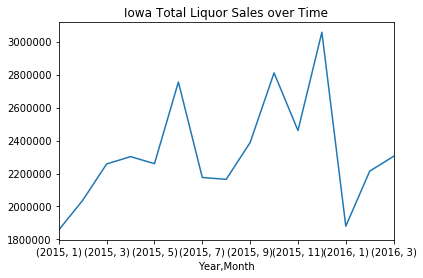

In [37]:
df.groupby(('Year', 'Month'))['Sale (Dollars)'].sum().plot()
plt.title('Iowa Total Liquor Sales over Time')
plt.show()
# Drop after new year.  Looking at the actual numbers though Jan, Feb, and Mar are all higher in 2016 than 2015.

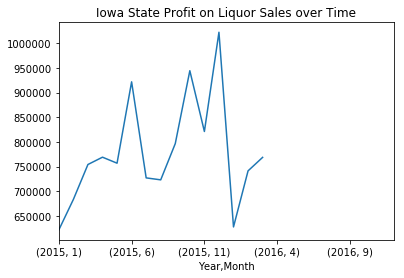

In [38]:
dfaf.groupby(('Year', 'Month'))['State Profit'].sum().plot()
plt.title('Iowa State Profit on Liquor Sales over Time')
plt.show()
# Roughly same shape by state profit; I was not sure if there were different profit (tax) margins for the State

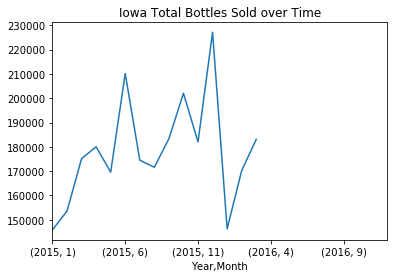

In [39]:
dfaf.groupby(('Year', 'Month'))['Bottles Sold'].sum().plot()
plt.title('Iowa Total Bottles Sold over Time')
plt.show()
# Very similar.  I am super curious if price per volume differs much as that could make using either Sales or Bottles not be a complete picture.
# Wish I could figure out store profit from this date.

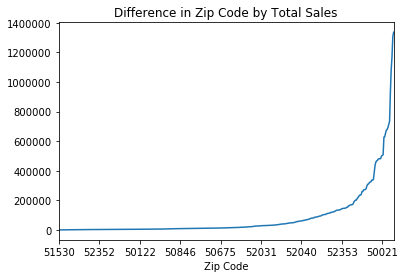

In [40]:
dfaf.groupby(('Zip Code'))['Sale (Dollars)'].sum().sort_values().plot()
plt.title('Difference in Zip Code by Total Sales')
plt.show()
# Looking to see if there are zip codes with more sales and, yes, there very much are

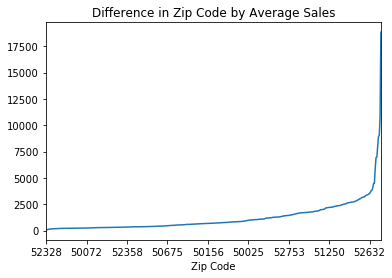

In [41]:
dfaf.groupby(('Zip Code'))['Sale (Dollars)'].mean().sort_values().plot()
plt.title('Difference in Zip Code by Average Sales')
plt.show()
# Checking for average sales as well

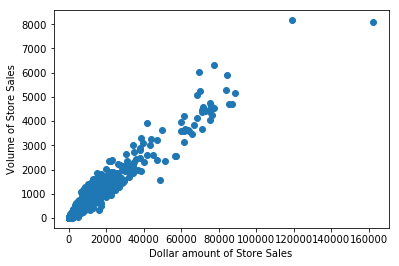

In [42]:
plt.scatter(dfaf['Sale (Dollars)'], dfaf['Volume Sold (Liters)'])
plt.xlabel('Dollar amount of Store Sales')
plt.ylabel('Volume of Store Sales')
plt.show()
# Reasonable, variance should reflect price per bottle
# If I want to know the best location, what I really want is profit.  I am not sure if Sale or Volume will be the best indicator.
# Price per volume? Ultimately it will be the store's descretion how much to mark up items.
# We'll start with sales as that should be a proxy for cashflow at the least.

In [43]:
avg_sale_store = dfaf.groupby(['Year', 'Month', 'City'], as_index=False)['Sale (Dollars)'].mean()
# This gives us the average sales per store in each city, over time.  
# Which I wanted to plot, but with so many cities I'm finding it uninterpretable.

In [44]:
avg_sale_store.groupby(['City'])['Sale (Dollars)'].mean().sort_values(ascending=False).head(25)
# This lists the mean sales per store per month.  Sorted to see which city has highest average sale by stores.
# Ultimately some form of this will be our target data we want to predict.

City
MT VERNON          16331.520000
MOUNT VERNON        8542.882667
MILFORD             7383.694333
WINDSOR HEIGHTS     6991.361311
OTTUWMA             4962.776667
BETTENDORF          4501.376306
CORALVILLE          4099.187229
DES MOINES          3958.240308
CARROLL             3866.805633
KEOKUK              3502.843273
IOWA CITY           3452.193989
ALGONA              2973.166889
LEMARS              2954.231000
WEST DES MOINES     2914.600152
CRESCO              2885.522000
DAVENPORT           2884.790409
AMES                2869.401208
CLINTON             2832.970791
MASON CITY          2812.817073
SPIRIT LAKE         2791.499978
DUBUQUE             2757.134193
WAUKEE              2755.329700
MARENGO             2718.268667
SHELDON             2686.116444
PELLA               2686.071333
Name: Sale (Dollars), dtype: float64

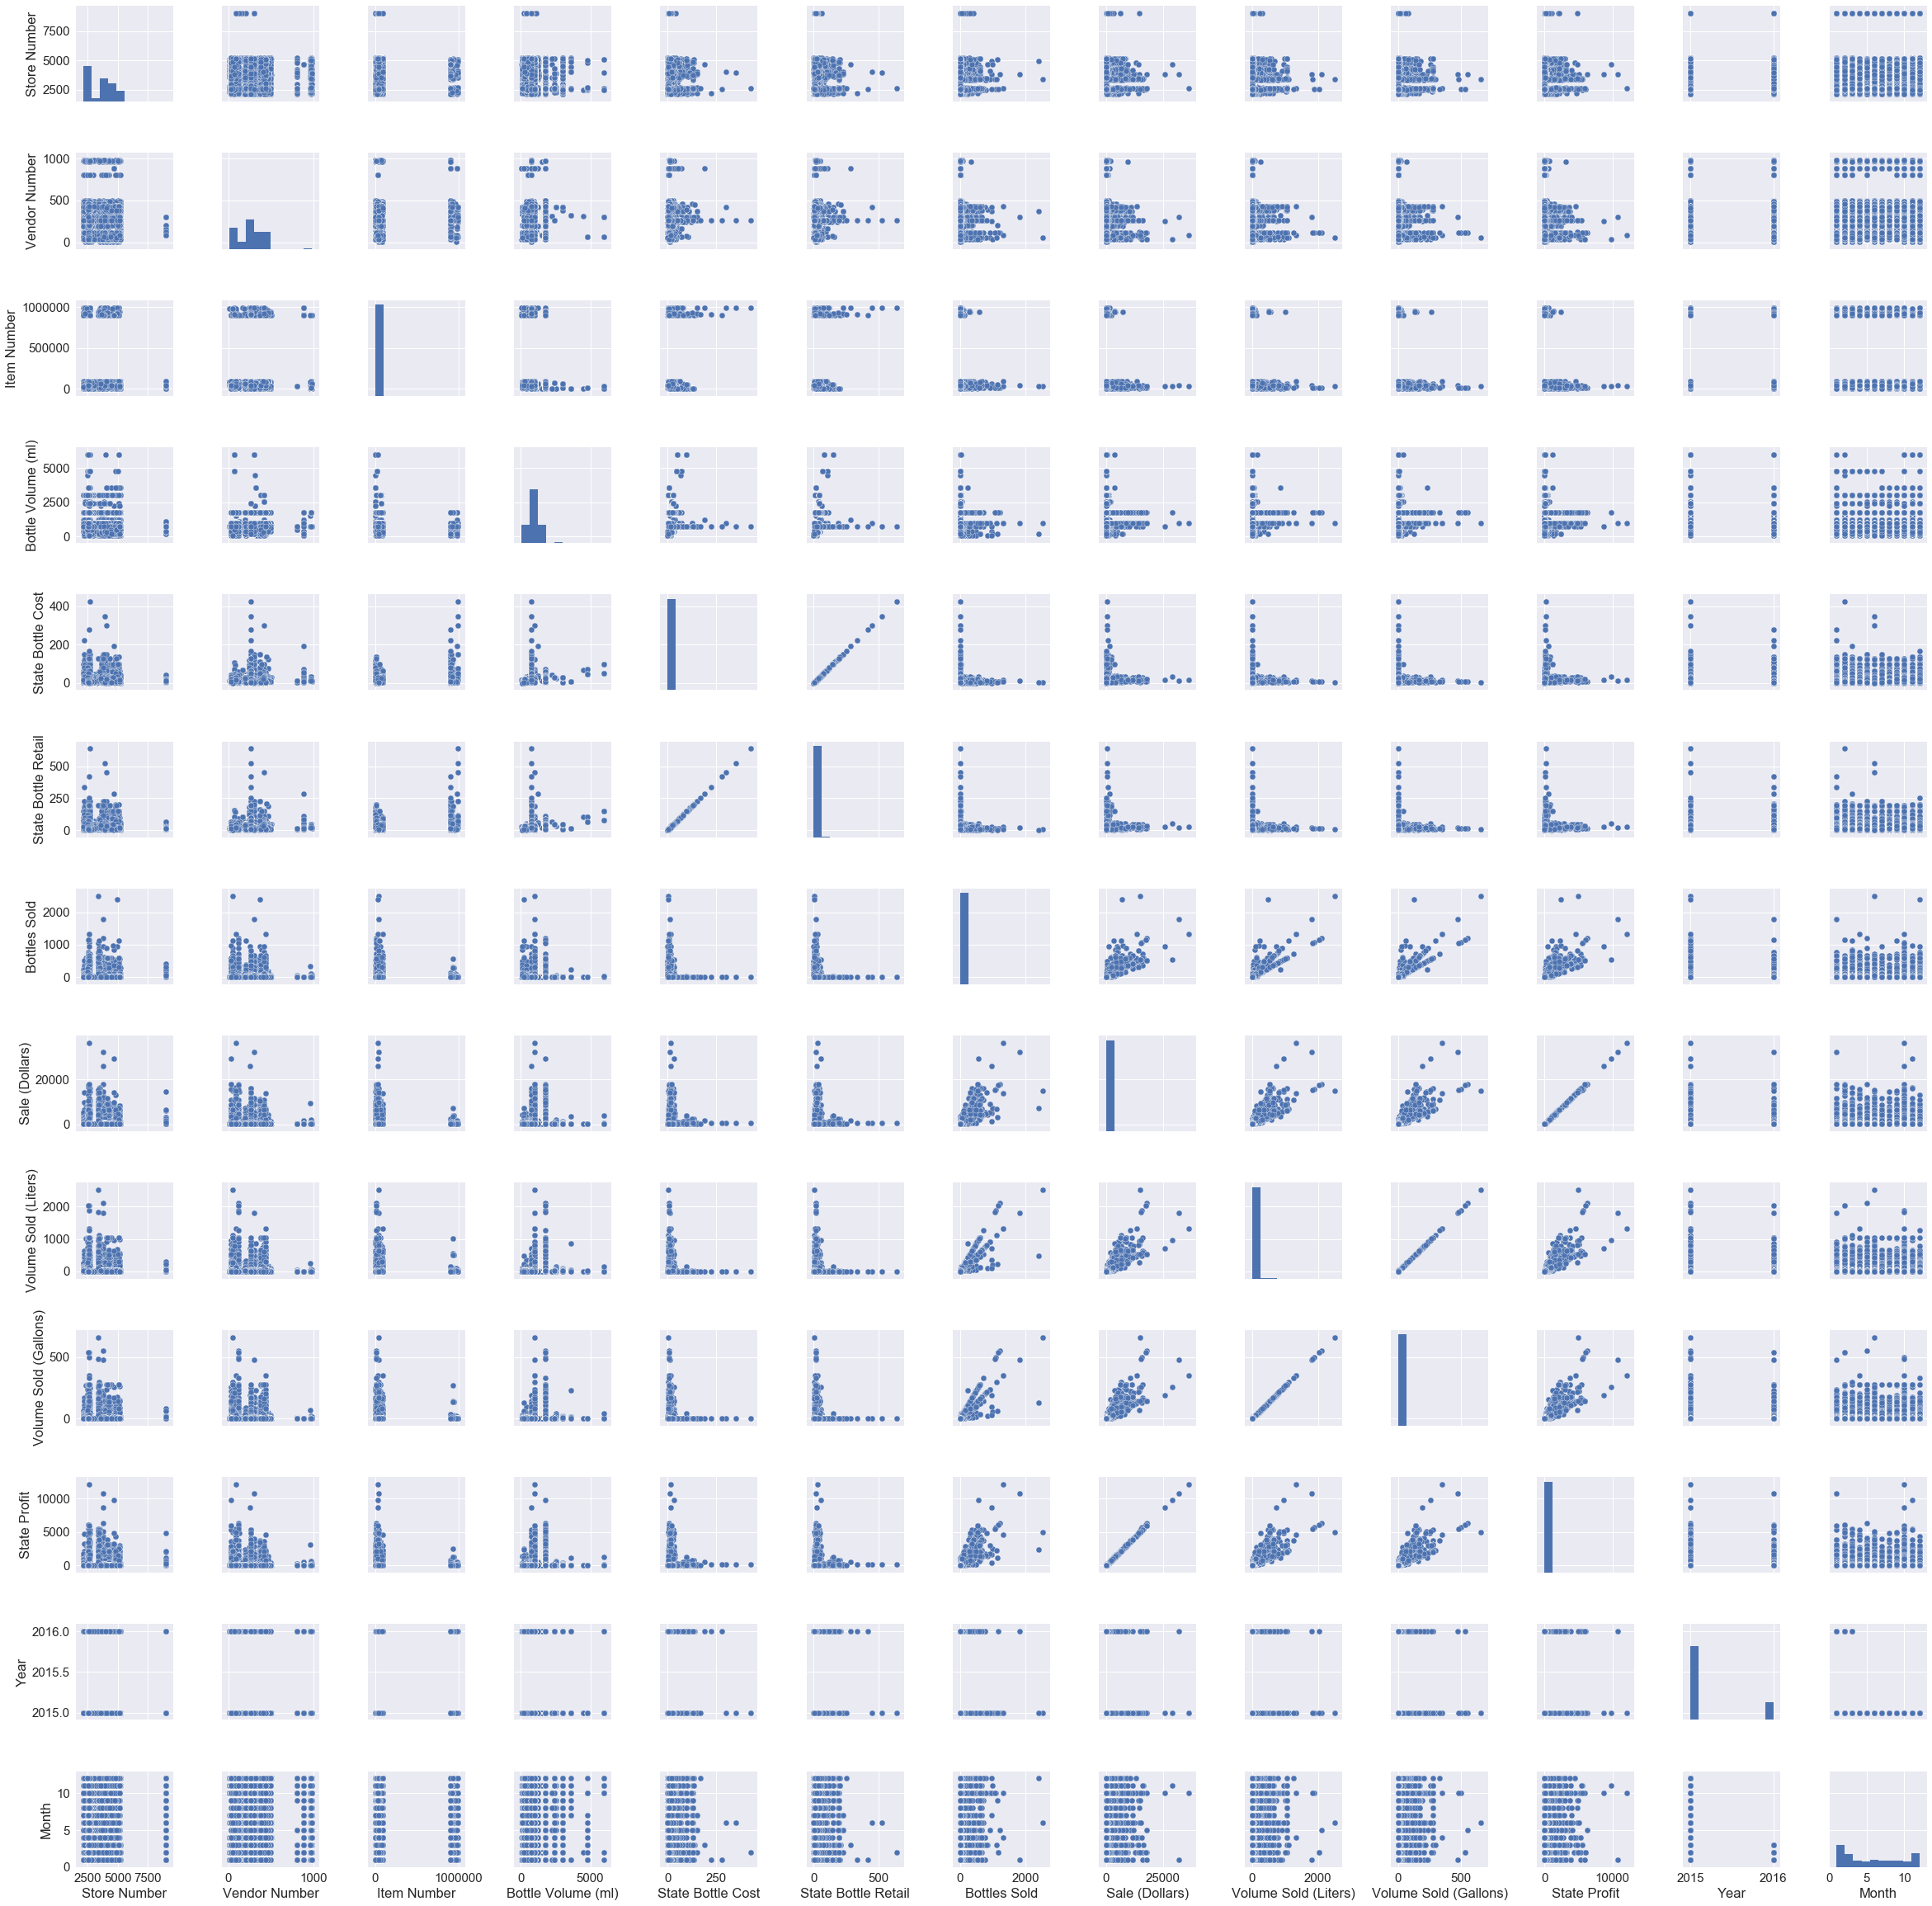

In [1843]:
# This beautiful beast compares each column against every other column.  It's useful to see if we notice any immediate relationships
# But my computer will rebel if I try to run it on the big boy 100% dataset.
sns.pairplot(df)

In [46]:
# Lot's of information here.  The obvious relationships are between bottle amount, volumnes, sales, prices.  These are of course calculated columns (Price times # of Bottles equals Sales; Bottle size time bottles sold equals volume)
# We will have to make our predictions using past data.  We will use Jan thru Mar data to try and predict total yearly sales.  We have the information for all of 2015 and Jan through Mar 2016.  We can thus build a model based on 2015 info and then compare it with actuals, then make predictions for 2016 (and perhaps later gather 2016 info and see how we've done).

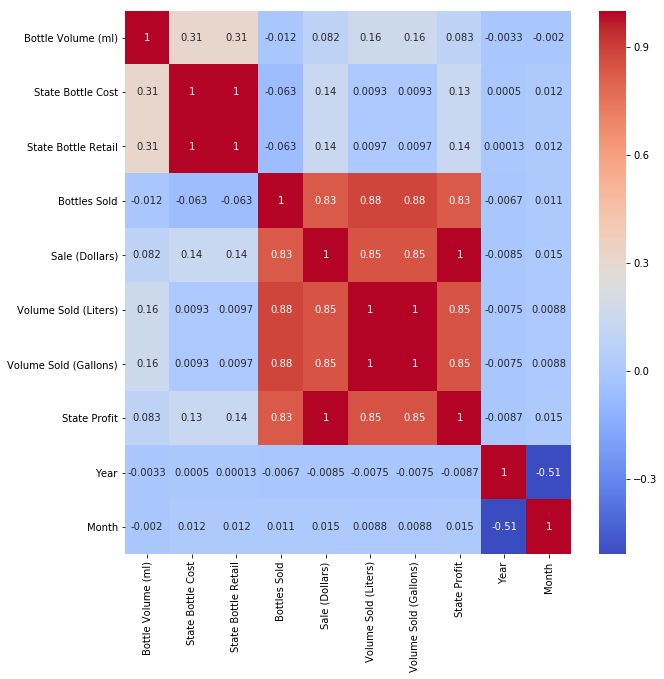

In [47]:
# Another good plot similar to above which shows us similar information numerically which can be useful for linear regressions
plt.rcParams['figure.figsize'] = 10, 10
sns.heatmap(df.corr(), cmap='coolwarm' , annot=True)

## I need Population data to make this meaningful

I really want to look at people per store.  Even if I only use one number population estimate per zip code, people per store should change over time as stores open and close.  Will have to calculate pop per store by month/year.

Data obtained from https://www.census.gov/.  Apparently the Census uses a zip code approximate that does not necessarily equate to postal zip codes.  I will therefore do my analysis at the city level.  Once top potential cities are chosen, a market analysis can be done for each to decide final location.

In [48]:
# Load up the population data
pop_data = pd.read_csv('/Users/dale/DSI/Datasets/Iowa/PEP_2016_PEPANNRES.csv', header=1)

In [49]:
# Make city names comprable to cities in our liquor dataset.
pop_data['Geography'] = pop_data['Geography'].apply(lambda x: x.replace(' city, Iowa', '').upper())
# Mad props to Chris Messier!  I was using rstrip and it was running amuk in my data.

In [50]:
#pop_data[pop_data['Geography'].str.contains('North', na='False')]['Geography'].unique()
# This was for testing to see if I am removing the correct parts of City name

In [1488]:
# Take a peak.
pop_data.head()

,Id,Id2,Geography,"April 1, 2010 - Census","April 1, 2010 - Estimates Base",Population Estimate (as of July 1) - 2010,Population Estimate (as of July 1) - 2011,Population Estimate (as of July 1) - 2012,Population Estimate (as of July 1) - 2013,Population Estimate (as of July 1) - 2014,Population Estimate (as of July 1) - 2015,Population Estimate (as of July 1) - 2016
0,0400000US19,19,IOWA,3046355,3046869,3050738,3065223,3076310,3091930,3108030,3121997,3134693
1,1620000US1900190,1900190,ACKLEY,1589,1589,1590,1577,1576,1567,1564,1552,1546
2,1620000US1900235,1900235,ACKWORTH,83,83,83,83,83,83,83,86,86
3,1620000US1900370,1900370,ADAIR,781,781,779,770,759,751,749,727,716
4,1620000US1900505,1900505,ADEL,3682,3711,3723,3818,3884,3969,4030,3995,4293


In [52]:
# We'll take a look at the actual data from 2010, but likely use their estimates for 2015 and 2016.
pop_add = pop_data[['Geography', 'April 1, 2010 - Census', 'Population Estimate (as of July 1) - 2015', 'Population Estimate (as of July 1) - 2016']]
# Rename columns for ease of use.
pop_add.columns = ['City', '2010_pop', '2015_pop_est', '2016_pop_est']
pop_add.head()

,City,2010_pop,2015_pop_est,2016_pop_est
0,IOWA,3046355,3121997,3134693
1,ACKLEY,1589,1552,1546
2,ACKWORTH,83,86,86
3,ADAIR,781,727,716
4,ADEL,3682,3995,4293


In [53]:
# After merging the two datasets, there were a number of cities in our liquor dataset that were spelled wrong or their names were changed over time.  Also a few naming conventions needed to be corrected to match.
# We are currently working with 10% of total, so this may need to be expanded when we tackle the big boy.
# dfaf verses pop:
# ST needs to match ST.
pop_add['City'] = pop_add['City'].apply(lambda x: x.replace('.', ''))
# MT needs to match MOUNT
dfaf['City'] = dfaf['City'].apply(lambda x: x.replace('MT', 'MOUNT'))
# OTTUWMA is misspelled and should be OTTUMWA
dfaf['City'] = dfaf['City'].apply(lambda x: x.replace('OTTUWMA', 'OTTUMWA'))
# LEMARS to match LE MARS
dfaf['City'] = dfaf['City'].apply(lambda x: x.replace('LEMARS', 'LE MARS'))
# DEWITT to match DE WITT
dfaf['City'] = dfaf['City'].apply(lambda x: x.replace('DEWITT', 'DE WITT'))
# KELLOG to match KELLOGG
dfaf['City'] = dfaf['City'].apply(lambda x: x.replace('KELLOG', 'KELLOGG'))
dfaf['City'] = dfaf['City'].apply(lambda x: x.replace('KELLOGGG', 'KELLOGG'))
# JEWELL to match JEWELL JUNCTION
dfaf['City'] = dfaf['City'].apply(lambda x: x.replace('JEWELL', 'JEWELL JUNCTION'))
# LECLAIRE to match LE CLAIRE
dfaf['City'] = dfaf['City'].apply(lambda x: x.replace('LECLAIRE', 'LE CLAIRE'))
# ARNOLD'S PARK to match ARNOLDS PARK
dfaf['City'] = dfaf['City'].apply(lambda x: x.replace("ARNOLD'S PARK", 'ARNOLDS PARK'))

#pop_add[pop_add['City'].str.contains('ST ', na='False')]['City'].unique()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [54]:
#df[df['City'].str.contains('DEWITT', na='False')]['City'].unique()
# using for matching

In [55]:
#dfaf[dfaf['City'].str.contains('WASHBURN')].sort_values(['Year', 'Month'])
# also using this to see if names change over time or whatever and checking with Google to verify

In [56]:
# The big merge
testmerge = pd.merge(dfaf, pop_add, how='left', on='City')
# And a look-through to see what didn't connect.
testmerge[(testmerge['2010_pop'].isnull() == True) & (testmerge['Bottle Volume (ml)'].isnull() != True)]['City'].unique()

array(['Dubuque', 'Northwood', 'WASHBURN', 'Urbandale', 'Inwood',
       'Cumming', 'Des Moines', 'Carroll'], dtype=object)

In [57]:
# WASHBURN.... not in the damn census?
# found it as an unencorporated area, but don't have much data on it.  Less than 1k people, may drop it.

In [58]:
# Let's see how the info was imported.
testmerge.dtypes

Year                        int64
Month                       int64
Store Number             category
Bottle Volume (ml)        float64
Bottles Sold              float64
Sale (Dollars)            float64
Volume Sold (Liters)      float64
Volume Sold (Gallons)     float64
State Profit              float64
City                       object
Zip Code                 category
State Bottle Cost         float64
State Bottle Retail       float64
2010_pop                  float64
2015_pop_est              float64
2016_pop_est              float64
dtype: object

In [59]:
# Looks good!
testmerge.head()

,Year,Month,Store Number,Bottle Volume (ml),Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),State Profit,City,Zip Code,State Bottle Cost,State Bottle Retail,2010_pop,2015_pop_est,2016_pop_est
0,2015,1,2106,40000.0,907.0,13567.80,836.75,221.07,4524.09,CEDAR FALLS,50613,9.750455,14.627727,39260.0,41345.0,41390.0
1,2015,1,2113,11625.0,66.0,813.68,51.49,13.62,271.35,GOWRIE,50543,10.230000,15.347333,1037.0,989.0,981.0
2,2015,1,2130,22700.0,442.0,7725.66,420.05,110.96,2575.96,WATERLOO,50703,11.402609,17.106087,68406.0,68414.0,67934.0
3,2015,1,2152,11625.0,62.0,1096.72,57.62,15.23,365.66,ROCKWELL,50469,11.882500,17.825000,1039.0,1011.0,1012.0
4,2015,1,2178,20675.0,179.0,2251.52,145.10,38.33,750.88,WAUKON,52172,9.721905,14.585714,3897.0,3743.0,3733.0


# Mine the data

Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations here for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.
 


## First up, I want to use that population data to get a population per store number by month

In [60]:
pps = testmerge.groupby(['Year', 'Month', 'City'], as_index=False)['Store Number'].count()

In [61]:
pps.columns = ['Year', 'Month', 'City', 'Monthly Stores in City']
pps = pd.merge(pps, pop_add, how='left', on='City')
pps.head()

,Year,Month,City,Monthly Stores in City,2010_pop,2015_pop_est,2016_pop_est
0,2015,1,ACKLEY,2,1589.0,1552.0,1546.0
1,2015,1,ADAIR,2,781.0,727.0,716.0
2,2015,1,ADEL,3,3682.0,3995.0,4293.0
3,2015,1,AFTON,1,845.0,828.0,832.0
4,2015,1,AKRON,1,1486.0,1454.0,1465.0


In [62]:
pps['Pop per Store'] = pps['2015_pop_est']/pps['Monthly Stores in City']
pps.head()

,Year,Month,City,Monthly Stores in City,2010_pop,2015_pop_est,2016_pop_est,Pop per Store
0,2015,1,ACKLEY,2,1589.0,1552.0,1546.0,776.000000
1,2015,1,ADAIR,2,781.0,727.0,716.0,363.500000
2,2015,1,ADEL,3,3682.0,3995.0,4293.0,1331.666667
3,2015,1,AFTON,1,845.0,828.0,832.0,828.000000
4,2015,1,AKRON,1,1486.0,1454.0,1465.0,1454.000000


In [63]:
pps['merge'] = pps['Year'].astype(str) + pps['Month'].astype(str) + pps['City'].astype(str)
testmerge['merge'] = testmerge['Year'].astype(str) + testmerge['Month'].astype(str) + testmerge['City'].astype(str)
pps2 = pps.drop(['Year', 'Month','City','2010_pop','2015_pop_est','2016_pop_est'], 1)
testmerge2 = pd.merge(testmerge, pps2, how='left', on='merge')
testmerge2.head()
# HAHAHAHA, i can't believe that worked!

,Year,Month,Store Number,Bottle Volume (ml),Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),State Profit,City,Zip Code,State Bottle Cost,State Bottle Retail,2010_pop,2015_pop_est,2016_pop_est,merge,Monthly Stores in City,Pop per Store
0,2015,1,2106,40000.0,907.0,13567.80,836.75,221.07,4524.09,CEDAR FALLS,50613,9.750455,14.627727,39260.0,41345.0,41390.0,20151CEDAR FALLS,17,2432.058824
1,2015,1,2113,11625.0,66.0,813.68,51.49,13.62,271.35,GOWRIE,50543,10.230000,15.347333,1037.0,989.0,981.0,20151GOWRIE,2,494.500000
2,2015,1,2130,22700.0,442.0,7725.66,420.05,110.96,2575.96,WATERLOO,50703,11.402609,17.106087,68406.0,68414.0,67934.0,20151WATERLOO,46,1487.260870
3,2015,1,2152,11625.0,62.0,1096.72,57.62,15.23,365.66,ROCKWELL,50469,11.882500,17.825000,1039.0,1011.0,1012.0,20151ROCKWELL,2,505.500000
4,2015,1,2178,20675.0,179.0,2251.52,145.10,38.33,750.88,WAUKON,52172,9.721905,14.585714,3897.0,3743.0,3733.0,20151WAUKON,3,1247.666667


In [64]:
testmerge2[testmerge2['Pop per Store'].isnull()]

,Year,Month,Store Number,Bottle Volume (ml),Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),State Profit,City,Zip Code,State Bottle Cost,State Bottle Retail,2010_pop,2015_pop_est,2016_pop_est,merge,Monthly Stores in City,Pop per Store
899,2015,1,4685,4250.0,214.0,1419.84,76.75,20.28,473.33,Dubuque,52001,6.946667,10.421111,NaN,NaN,NaN,20151Dubuque,2,NaN
1038,2015,1,4839,7250.0,35.0,655.80,44.25,11.70,222.67,Northwood,50459,10.932857,16.545714,NaN,NaN,NaN,20151Northwood,1,NaN
1152,2015,1,4980,750.0,6.0,90.00,4.50,1.19,30.00,WASHBURN,50702,10.000000,15.000000,NaN,NaN,NaN,20151WASHBURN,1,NaN
1225,2015,1,5058,NaN,NaN,NaN,NaN,NaN,NaN,Urbandale,50323,NaN,NaN,NaN,NaN,NaN,20151Urbandale,1,NaN
1279,2015,1,5112,NaN,NaN,NaN,NaN,NaN,NaN,Inwood,51240,NaN,NaN,NaN,NaN,NaN,20151Inwood,1,NaN
1333,2015,1,5169,NaN,NaN,NaN,NaN,NaN,NaN,Des Moines,50313,NaN,NaN,NaN,NaN,NaN,20151Des Moines,1,NaN
1397,2015,1,9013,NaN,NaN,NaN,NaN,NaN,NaN,Cumming,50061,NaN,NaN,NaN,NaN,NaN,20151Cumming,1,NaN
1398,2015,1,9018,NaN,NaN,NaN,NaN,NaN,NaN,Dubuque,52001,NaN,NaN,NaN,NaN,NaN,20151Dubuque,2,NaN
1399,2015,1,9023,NaN,NaN,NaN,NaN,NaN,NaN,Carroll,51401,NaN,NaN,NaN,NaN,NaN,20151Carroll,1,NaN
2299,2015,2,4685,1325.0,40.0,314.84,14.40,3.80,104.96,Dubuque,52001,5.823333,8.736667,NaN,NaN,NaN,20152Dubuque,2,NaN


In [65]:
testmerge2 = testmerge2.drop('merge', 1)

## OK, according to Stack Overflow, I basically have two options for the date.  I can convert to ordinal or I can use categories.

## I think I would prefer ordinals, but since it really appears that there are significant trends by month, categories are probably best.

In [66]:
year = pd.get_dummies(testmerge2['Year'])

In [67]:
month = pd.get_dummies(testmerge2['Month'])

In [68]:
month.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0


In [69]:
# It makes sense to drop January as that appears to be the lowest month for sales (December hangover presumably)
# Not sure about year... 2015?  If I interpreted it, I could say 2016 looks to be X over 2015.  Makes sense.
testmerge2 = testmerge2.join(year.drop(2015, 1))
testmerge2 = testmerge2.join(month.drop('Jan', 1))
print(testmerge2.head())

   Year  Month Store Number  Bottle Volume (ml)  Bottles Sold  Sale (Dollars)  \
0  2015      1         2106             40000.0         907.0        13567.80   
1  2015      1         2113             11625.0          66.0          813.68   
2  2015      1         2130             22700.0         442.0         7725.66   
3  2015      1         2152             11625.0          62.0         1096.72   
4  2015      1         2178             20675.0         179.0         2251.52   

   Volume Sold (Liters)  Volume Sold (Gallons)  State Profit         City  \
0                836.75                 221.07       4524.09  CEDAR FALLS   
1                 51.49                  13.62        271.35       GOWRIE   
2                420.05                 110.96       2575.96     WATERLOO   
3                 57.62                  15.23        365.66     ROCKWELL   
4                145.10                  38.33        750.88       WAUKON   

  ...  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov

## Now for location...

In [70]:
testmerge2.groupby('City')['Store Number'].count().sort_values(ascending=False).head(10)

City
DES MOINES         2136
CEDAR RAPIDS       1848
WATERLOO           1104
DAVENPORT          1056
COUNCIL BLUFFS     1008
SIOUX CITY          816
WEST DES MOINES     720
DUBUQUE             696
IOWA CITY           624
AMES                600
Name: Store Number, dtype: int64

In [71]:
# I suppose I will drop Des Moines and just compare everything to the it.
cities = pd.get_dummies(testmerge2['City'])
testmerge2 = testmerge2.join(cities.drop('DES MOINES', 1))

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [72]:
import statsmodels.api as sm

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [73]:
# Our groupby's created lots of additional rows.  
# There are now rows for each store in every month and months extending until Dec 2016, none of which have data we can use
testmerge2.dropna(inplace=True)

In [74]:
# Let's see what we dropped.
testmerge2.shape
#ok, that's something

(17626, 406)

In [75]:
df.shape
# hmmmm

(270955, 21)

In [76]:
33600/24 * 15
# This would be the amount IF all stores had entries for all months, which is not the case.  
# Also, still lost Washburn.

21000.0

In [77]:
print(dfaf.shape)
dfaf.tail()
# Right, dfaf is df.groupby that rolls all transactions up by store and date.  
# It adds Apr through Dec 2016, but there is no real data.

(33600, 13)


,Year,Month,Store Number,Bottle Volume (ml),Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),State Profit,City,Zip Code,State Bottle Cost,State Bottle Retail
33595,2016,12,9002,NaN,NaN,NaN,NaN,NaN,NaN,LE CLAIRE,52753,NaN,NaN
33596,2016,12,9010,NaN,NaN,NaN,NaN,NaN,NaN,NORWALK,50211,NaN,NaN
33597,2016,12,9013,NaN,NaN,NaN,NaN,NaN,NaN,Cumming,50061,NaN,NaN
33598,2016,12,9018,NaN,NaN,NaN,NaN,NaN,NaN,Dubuque,52001,NaN,NaN
33599,2016,12,9023,NaN,NaN,NaN,NaN,NaN,NaN,Carroll,51401,NaN,NaN


In [78]:
dfaf.dropna().shape
# OK, this is comparible

(17704, 13)

In [79]:
testmerge2.columns

Index([                 'Year',                 'Month',
                'Store Number',    'Bottle Volume (ml)',
                'Bottles Sold',        'Sale (Dollars)',
        'Volume Sold (Liters)', 'Volume Sold (Gallons)',
                'State Profit',                  'City',
       ...
                  'WEST UNION',             'WHEATLAND',
                'WILLIAMSBURG',                'WILTON',
             'WINDSOR HEIGHTS',             'WINTERSET',
                    'WINTHROP',              'WOODBINE',
                    'WOODWARD',               'ZWINGLE'],
      dtype='object', length=406)

In [80]:
predictors = testmerge2.drop(['Year', 'Month', 'Store Number', 'Bottle Volume (ml)', 'Bottles Sold', 'Sale (Dollars)', 'Volume Sold (Liters)', 'Volume Sold (Gallons)', 'State Profit', 'City', 'Zip Code', 'State Bottle Retail', 'State Bottle Cost', '2015_pop_est', '2016_pop_est'], 1)

In [81]:
target = testmerge2['Sale (Dollars)']
target.head()

0    13567.80
1      813.68
2     7725.66
3     1096.72
4     2251.52
Name: Sale (Dollars), dtype: float64

In [82]:
X = predictors # A swing and a try
y = target # Average greenbacks per month
X = sm.add_constant(X) 
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Sale (Dollars)   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     3.130
Date:                Wed, 18 Oct 2017   Prob (F-statistic):           2.89e-80
Time:                        11:42:24   Log-Likelihood:            -1.7389e+05
No. Observations:               17626   AIC:                         3.485e+05
Df Residuals:                   17245   BIC:                         3.515e+05
Df Model:                         380                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -210.2192    184.572     -1.139      0.255    -571.998     151.560
2010_pop                  -0.0249      0.006     -3.940      0.000      -0.037      -0.013
Monthly Stores in City    85.0885     14.108      6.031      0.000      57.435     112.742
Pop per Store              0.5323      0.092      5.788      0.000       0.352       0.713
2016                      -6.3724    112.766     -0.057      0.955    -227.406     214.661
Feb                      237.2012    138.333      1.715      0.086     -33.945     508.348
Mar                      339.1905    137.647      2.464      0.014      69.389     608.992
Apr                      380.6904    179.378      2.122      0.034      29.091     732.290
May                      320.7562    178.318      1.799      0.072     -28.765     670.277
Jun                      737.6474    177.763      4.150      0.000     389.214    1086.081
Jul                      242.2715    178.100      1.360      0.174    -106.823     591.366
Aug                      255.9730    178.349      1.435      0.151     -93.609     605.555
Sep                      423.5857    178.086      2.379      0.017      74.520     772.651
Oct                      799.3973    178.510      4.478      0.000     449.500    1149.294
Nov                      483.4168    177.898      2.717      0.007     134.718     832.115
Dec                      922.8938    176.502      5.229      0.000     576.931    1268.856
ACKLEY                  -425.5763    875.381     -0.486      0.627   -2141.412    1290.259
ADAIR                   -242.6172   1079.490     -0.225      0.822   -2358.527    1873.292
ADEL                     353.2025    807.772      0.437      0.662   -1230.113    1936.518
AFTON                   -297.0384   1566.607     -0.190      0.850   -3367.747    2773.670
AKRON                   -627.2108   1214.040     -0.517      0.605   -3006.853    1752.432
ALBIA                   -158.0388    859.379     -0.184      0.854   -1842.510    1526.432
ALDEN                     37.6283   1052.397      0.036      0.971   -2025.178    2100.434
ALGONA                  1717.2961    703.146      2.442      0.015     339.058    3095.535
ALLISON                 -311.0420    942.420     -0.330      0.741   -2158.282    1536.198
ALTA                    -868.6226   1772.558     -0.490      0.624   -4343.017    2605.772
ALTOONA                  687.7250    416.558      1.651      0.099    -128.772    1504.222
AMES                     653.0709    274.553      2.379      0.017     114.920    1191.222
ANAMOSA                 1344.7173    905.645      1.485      0.138    -430.438    3119.873
ANITA                   -151.0505    961.637     -0.157      0.875   -2035.958    1733.857
ANKENY                   106.4902    290.175      0.367      0.714    -462.282  

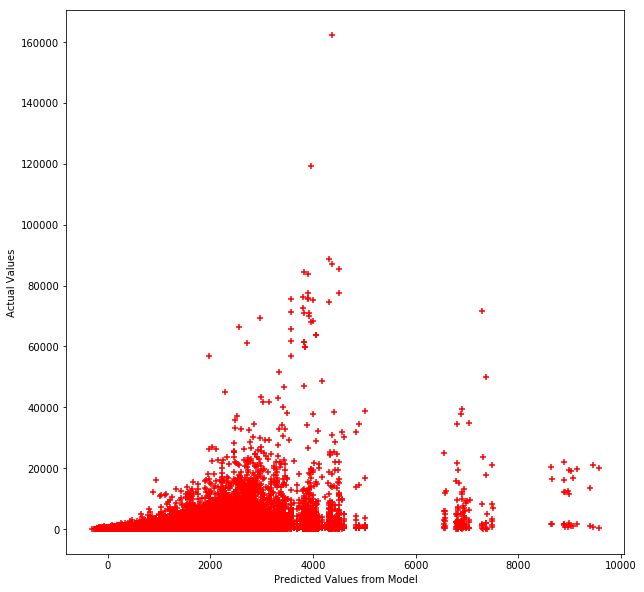

Mean Squared Error: 69446974.1677


In [83]:
# Let's see how she looks
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values from Model")
plt.ylabel("Actual Values")
plt.show()
print("Mean Squared Error:", model.mse_model)

## Looking at changing targets

Up to this point have been trying to predict average MONTHLY sales by store based on month/year, location, and population by store (and also tried city population and number of stores by city though those are all related).

I will now try to predict average yearly store sales by city.  This should give us target cities and allow us to predict average yearly sales.  I should still be able to use population by store, # of stores per city (related, but not as closely as when predicting average store sales), and also be able to use Jan - Mar average store sales to predict total yearly sales.

In [84]:
citytarget = testmerge2.groupby('City', as_index=False)['Sale (Dollars)'].sum()
citytarget['Sales per Store'] = citytarget['Sale (Dollars)']/testmerge2.groupby('City', as_index=False)['Monthly Stores in City'].mean()['Monthly Stores in City']

In [85]:
features = testmerge2.groupby('City', as_index=False)['Pop per Store', '2010_pop', 'Monthly Stores in City'].mean()
features.head()

,City,Pop per Store,2010_pop,Monthly Stores in City
0,ACKLEY,776.000000,1589.0,2
1,ADAIR,363.500000,781.0,2
2,ADEL,1331.666667,3682.0,3
3,AFTON,828.000000,845.0,1
4,AKRON,1454.000000,1486.0,1


In [86]:
# Add columns for January 2015 average store sales and volume sold
features = pd.merge(features, dfaf[(dfaf['Year']==2015) & (dfaf['Month']==1)].groupby('City', as_index=False)[['Sale (Dollars)', 'Volume Sold (Liters)']].mean(), how='left', on='City')
features.columns = ['City', 'Pop per Store', '2010_pop', 'Monthly Stores in City',
       'Jan_2015_Sales', 'Jan_2015_Volume_Sold(L)']

In [87]:
# And February
features = pd.merge(features, dfaf[(dfaf['Year']==2015) & (dfaf['Month']==2)].groupby('City', as_index=False)[['Sale (Dollars)', 'Volume Sold (Liters)']].mean(), how='left', on='City')
features.columns = ['City', 'Pop per Store', '2010_pop', 'Monthly Stores in City',
       'Jan_2015_Sales', 'Jan_2015_Volume_Sold(L)', 'Feb_2015_Sales', 'Feb_2015_Volume_Sold(L)']

In [88]:
# And March
features = pd.merge(features, dfaf[(dfaf['Year']==2015) & (dfaf['Month']==3)].groupby('City', as_index=False)[['Sale (Dollars)', 'Volume Sold (Liters)']].mean(), how='left', on='City')
features.columns = ['City', 'Pop per Store', '2010_pop', 'Monthly Stores in City',
       'Jan_2015_Sales', 'Jan_2015_Volume_Sold(L)', 'Feb_2015_Sales', 'Feb_2015_Volume_Sold(L)', 'Mar_2015_Sales', 'Mar_2015_Volume_Sold(L)']

In [89]:
features.head()
# Hmmm, some NaN's.  Those should be zero sales.

,City,Pop per Store,2010_pop,Monthly Stores in City,Jan_2015_Sales,Jan_2015_Volume_Sold(L),Feb_2015_Sales,Feb_2015_Volume_Sold(L),Mar_2015_Sales,Mar_2015_Volume_Sold(L)
0,ACKLEY,776.000000,1589.0,2,541.68,59.625,136.530000,13.875000,255.84,22.5
1,ADAIR,363.500000,781.0,2,467.28,36.000,259.380000,16.800000,393.00,24.0
2,ADEL,1331.666667,3682.0,3,895.92,66.625,870.296667,55.273333,3627.54,265.5
3,AFTON,828.000000,845.0,1,450.00,27.000,NaN,NaN,279.12,9.0
4,AKRON,1454.000000,1486.0,1,584.47,32.700,215.250000,23.250000,449.62,49.2


In [90]:
citytarget.head()

,City,Sale (Dollars),Sales per Store
0,ACKLEY,8305.00,4152.500000
1,ADAIR,5851.20,2925.600000
2,ADEL,47716.10,15905.366667
3,AFTON,3262.08,3262.080000
4,AKRON,5469.42,5469.420000


Let's see how these new features look!

In [91]:
X = features.drop(['City', '2010_pop'], 1).fillna(0)
y = citytarget.drop(['City', 'Sale (Dollars)'],1)
X = sm.add_constant(X) 
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)
model.summary()
# Now that's more like it!

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Sales per Store   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     485.0
Date:                Wed, 18 Oct 2017   Prob (F-statistic):          1.23e-187
Time:                        11:42:24   Log-Likelihood:                -3574.3
No. Observations:                 369   AIC:                             7167.
Df Residuals:                     360   BIC:                             7202.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     -73.0248    397.057     -0.184      0.854    -853.868     707.818
Pop per Store               2.3444      0.295      7.939      0.000       1.764       2.925
Monthly Stores in City     16.0482     29.293      0.548      0.584     -41.558      73.655
Jan_2015_Sales              5.3166      1.112      4.780      0.000       3.129       7.504
Jan_2015_Volume_Sold(L)   -40.2727     12.321     -3.269      0.001     -64.502     -16.043
Feb_2015_Sales              8.6050      0.961      8.958      0.000       6.716      10.494
Feb_2015_Volume_Sold(L)   -58.7421      9.446     -6.219      0.000     -77.318     -40.166
Mar_2015_Sales              5.5368      0.896      6.179      0.000       3.775       7.299
Mar_2015_Volume_Sold(L)   -11.5148     10.589     -1.087      0.278     -32.338       9.309
==============================================================================
Omnibus:                       99.302   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              369.051
Skew:                           1.144   Prob(JB):                     7.27e-81
Kurtosis:                       7.332   Cond. No.                     5.16e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

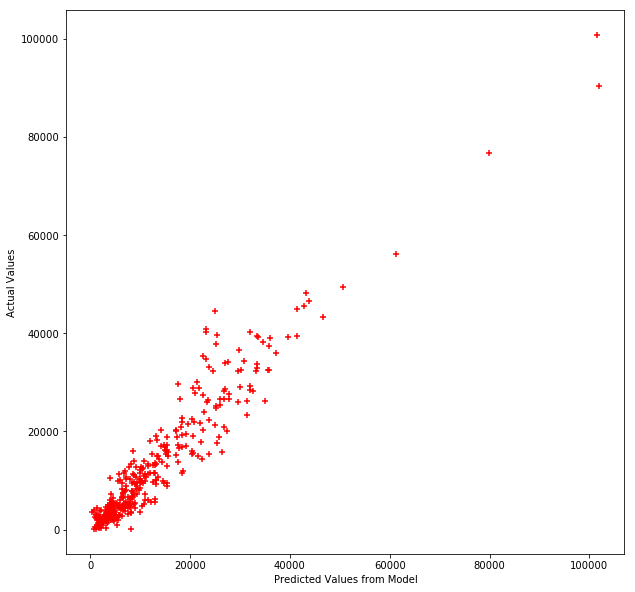

Mean Squared Error: 86849.6740436


In [92]:
# And plot the predictions against the actual values
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values from Model")
plt.ylabel("Actual Values")
plt.show()
print("Mean Squared Error:", np.sqrt(model.mse_model))

Alright, let's do some validation to predict how we'll do once we look at more data

In [93]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn import linear_model

In [94]:
lm = linear_model.LinearRegression()
model = lm.fit(X, y)
scores = cross_val_score(model, X, y, cv=10)

In [95]:
print("Cross-validated scores:", scores)
print("Average: ", scores.mean())

Cross-validated scores: [ 0.82494337  0.89957357  0.92553974  0.81903208  0.90826605  0.8542764
  0.91072126  0.88003137  0.80650283  0.86530201]
Average:  0.869418868585


Cross-Predicted Accuracy: 0.879337453349


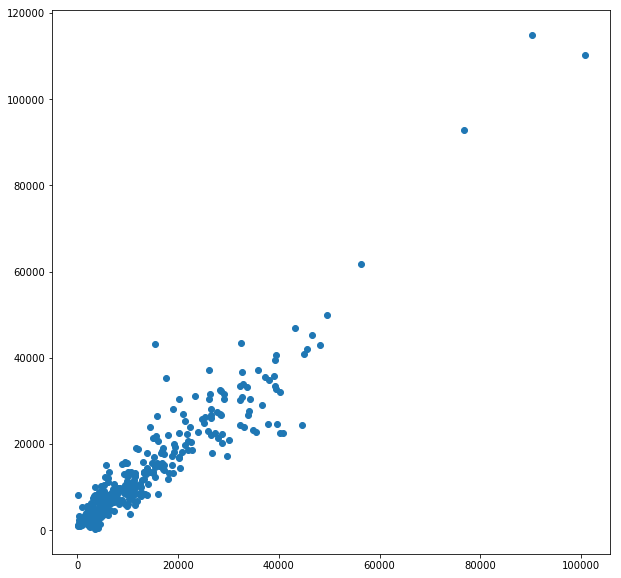

In [96]:
predictions = cross_val_predict(model, X, y, cv=10)
plt.scatter(y, predictions)
accuracy = metrics.r2_score(y, predictions)
print("Cross-Predicted Accuracy:", accuracy)
# Not too shabby.

Let's also do a bit of regulatization to see which of our coefficients are actually useful.

In [97]:
from sklearn.linear_model import LassoCV
lassoregcv = LassoCV(n_alphas=10, normalize=True, random_state=1)
lassoregcv.fit(X, y)
lassoregcv.alpha_

/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6.0906657768144123

In [98]:
from sklearn.linear_model import Lasso
lassoreg = Lasso(alpha=6.061, normalize=True)
lassoreg.fit(X, y)
print(lassoreg.coef_)

[  0.           2.16990222  60.13269194   2.43823236  -0.           5.55714245
 -25.69486302   4.96604136  -0.        ]


In [99]:
y_pred = lassoreg.predict(X)
print(np.sqrt(metrics.mean_squared_error(y, y_pred)))
# Much better mean squared error

4092.79991591


In [100]:
#for i, f in enumerate(features.drop(['City', '2010_pop'], 1).columns):
#    print(f, lassoregcv.coef_[i])
# ALL THAT WORK FOR POP PER STORE...
# WAIT!  Forgot about the coefficient
for i, f in enumerate(features.drop(['City', '2010_pop'], 1).columns):
    print(f, lassoregcv.coef_[i+1])
# Much better.  I do wonder if this will turn out the same with the full dataset.  I'll leave this process in and compare.

Pop per Store 2.1691764232
Monthly Stores in City 60.2312173216
Jan_2015_Sales 2.44118446361
Jan_2015_Volume_Sold(L) -0.0
Feb_2015_Sales 5.53678236235
Feb_2015_Volume_Sold(L) -25.4859681179
Mar_2015_Sales 4.96783355383
Mar_2015_Volume_Sold(L) -0.0


In [101]:
X = features.drop(['City', '2010_pop', 'Jan_2015_Volume_Sold(L)', 'Mar_2015_Volume_Sold(L)'], 1).fillna(0)
# Not sure why February volume is important, but ok
y = citytarget.drop(['City', 'Sale (Dollars)'],1)
X = sm.add_constant(X) 
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Sales per Store   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     626.7
Date:                Wed, 18 Oct 2017   Prob (F-statistic):          8.57e-188
Time:                        11:42:25   Log-Likelihood:                -3580.5
No. Observations:                 369   AIC:                             7175.
Df Residuals:                     362   BIC:                             7202.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     -52.0125    402.484     -0.129      0.897    -843.513     739.488
Pop per Store               2.3184      0.299      7.752      0.000       1.730       2.906
Monthly Stores in City     39.7285     28.903      1.375      0.170     -17.110      96.567
Jan_2015_Sales              1.8271      0.319      5.726      0.000       1.200       2.455
Feb_2015_Sales              9.7573      0.889     10.973      0.000       8.009      11.506
Feb_2015_Volume_Sold(L)   -68.7562      8.831     -7.786      0.000     -86.122     -51.391
Mar_2015_Sales              4.5955      0.314     14.645      0.000       3.978       5.213
==============================================================================
Omnibus:                       79.783   Durbin-Watson:                   2.119
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              288.005
Skew:                           0.914   Prob(JB):                     2.89e-63
Kurtosis:                       6.923   Cond. No.                     5.15e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [102]:
lm = linear_model.LinearRegression()
model = lm.fit(X, y)
scores = cross_val_score(model, X, y, cv=10)

In [103]:
print("Cross-validated scores:", scores)
print("Average: ", scores.mean())

Cross-validated scores: [ 0.83314598  0.90475751  0.90873299  0.84762366  0.90737822  0.87112742
  0.90269447  0.88684813  0.80694749  0.93477746]
Average:  0.880403332435


Cross-Predicted Accuracy: 0.893344678245


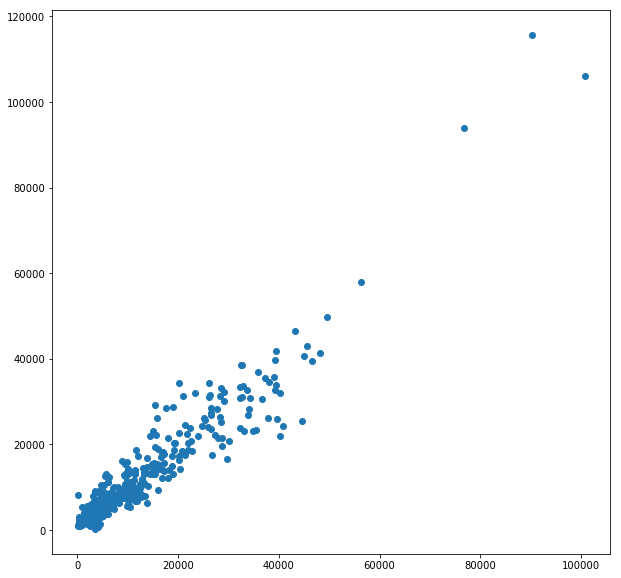

In [104]:
predictions = cross_val_predict(model, X, y, cv=10)
plt.scatter(y, predictions)
accuracy = metrics.r2_score(y, predictions)
print("Cross-Predicted Accuracy:", accuracy)
# Small increase in accuracy.

# Alright!  Time to bring in the big boy

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.

In [1758]:
bigboy = pd.read_csv('/Users/dale/DSI/Datasets/Iowa/iowa_liquor_sales_proj_2.csv', na_filter=False)

/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6,8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [1759]:
bigboy.columns

Index(['Invoice/Item Number', 'Date', 'Store Number', 'Store Name', 'Address',
       'City', 'Zip Code', 'Store Location', 'County Number', 'County',
       'Category', 'Category Name', 'Vendor Number', 'Vendor Name',
       'Item Number', 'Item Description', 'Pack', 'Bottle Volume (ml)',
       'State Bottle Cost', 'State Bottle Retail', 'Bottles Sold',
       'Sale (Dollars)', 'Volume Sold (Liters)', 'Volume Sold (Gallons)'],
      dtype='object')

In [1760]:
df.columns

Index(['Date', 'Store Number', 'City', 'Zip Code', 'County Number', 'County',
       'Category', 'Category Name', 'Vendor Number', 'Item Number',
       'Item Description', 'Bottle Volume (ml)', 'State Bottle Cost',
       'State Bottle Retail', 'Bottles Sold', 'Sale (Dollars)',
       'Volume Sold (Liters)', 'Volume Sold (Gallons)', 'State Profit', 'Year',
       'Month'],
      dtype='object')

In [1761]:
bigboy = bigboy.drop(['Invoice/Item Number', 'Store Name', 'Address', 'Store Location', 'Vendor Name', 'Pack'], 1)

In [1762]:
bigboy.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,11/20/2015,2191,KEOKUK,52632,56,Lee,,,255,297,Templeton Rye w/Flask,750,$18.09,$27.14,6,$162.84,4.50,1.19
1,11/21/2015,2205,CLARINDA,51632,73,Page,,,255,297,Templeton Rye w/Flask,750,$18.09,$27.14,12,$325.68,9.00,2.38
2,11/16/2015,3549,FORT MADISON,52627,56,Lee,,,130,249,Disaronno Amaretto Cavalli Mignon 3-50ml Pack,150,$6.40,$9.60,2,$19.20,0.30,0.08
3,11/04/2015,2513,IOWA CITY,52240,52,Johnson,,,65,237,Knob Creek w/ Crystal Decanter,1750,$35.55,$53.34,3,$160.02,5.25,1.39
4,11/17/2015,3942,TOLEDO,52342,86,Tama,,,130,249,Disaronno Amaretto Cavalli Mignon 3-50ml Pack,150,$6.40,$9.60,2,$19.20,0.30,0.08


In [1763]:
bigboy["Date"] = pd.to_datetime(bigboy["Date"], infer_datetime_format=True)
# Fix my date column

In [1764]:
bigboy["Store Number"] = bigboy["Store Number"].astype('category')
bigboy["City"] = bigboy["City"].astype('category')
bigboy["Zip Code"] = bigboy["Zip Code"].astype('category')
bigboy["County Number"] = bigboy["County Number"].astype('category')
bigboy["County"] = bigboy["County"].astype('category')
bigboy["Category"] = bigboy["Category"].astype('category')
bigboy["Category Name"] = bigboy["Category Name"].astype('category')
bigboy["Vendor Number"] = bigboy["Vendor Number"].astype('category')
bigboy["Item Number"] = bigboy["Item Number"].astype('category')
bigboy["Item Description"] = bigboy["Item Description"].astype('category')
# Change category columns to dtype category

In [1765]:
bigboy["State Bottle Cost"] = bigboy["State Bottle Cost"].apply(lambda x: x.strip('$')).astype(float)
bigboy["State Bottle Retail"] = bigboy["State Bottle Retail"].apply(lambda x: x.strip('$')).astype(float)
bigboy["Sale (Dollars)"] = bigboy["Sale (Dollars)"].apply(lambda x: x.strip('$')).astype(float)
# Change dollar amounts to floats for calculations

In [1766]:
bigboy["Year"] = bigboy['Date'].dt.year
bigboy['Month'] = bigboy['Date'].dt.month

In [1767]:
# City name change GUTTENBURG to GUTTENBERG
bigboy['City'] = bigboy['City'].str.replace('GUTTENBURG', 'GUTTENBERG')

In [1768]:
bigboy.dtypes

Date                     datetime64[ns]
Store Number                   category
City                             object
Zip Code                       category
County Number                  category
County                         category
Category                       category
Category Name                  category
Vendor Number                  category
Item Number                    category
Item Description               category
Bottle Volume (ml)                int64
State Bottle Cost               float64
State Bottle Retail             float64
Bottles Sold                      int64
Sale (Dollars)                  float64
Volume Sold (Liters)            float64
Volume Sold (Gallons)           float64
Year                              int64
Month                             int64
dtype: object

In [1769]:
bigboy.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Year,Month
0,2015-11-20,2191,KEOKUK,52632,56,Lee,,,255,297,Templeton Rye w/Flask,750,18.09,27.14,6,162.84,4.50,1.19,2015,11
1,2015-11-21,2205,CLARINDA,51632,73,Page,,,255,297,Templeton Rye w/Flask,750,18.09,27.14,12,325.68,9.00,2.38,2015,11
2,2015-11-16,3549,FORT MADISON,52627,56,Lee,,,130,249,Disaronno Amaretto Cavalli Mignon 3-50ml Pack,150,6.40,9.60,2,19.20,0.30,0.08,2015,11
3,2015-11-04,2513,IOWA CITY,52240,52,Johnson,,,65,237,Knob Creek w/ Crystal Decanter,1750,35.55,53.34,3,160.02,5.25,1.39,2015,11
4,2015-11-17,3942,TOLEDO,52342,86,Tama,,,130,249,Disaronno Amaretto Cavalli Mignon 3-50ml Pack,150,6.40,9.60,2,19.20,0.30,0.08,2015,11


In [181]:
new_df = bigboy.groupby(['Year', 'Month', 'Store Number'], as_index=False).sum()
new_df.shape

(33672, 10)

In [182]:
add_cols = bigboy[['Store Number', 'City']].drop_duplicates()

In [183]:
new_df = pd.merge(new_df, add_cols, how='left', on='Store Number')
new_df['Store Number'].value_counts().sort_values(ascending=False).head(5)
# OK, all good now

2106    24
2205    24
2228    24
2113    24
2130    24
Name: Store Number, dtype: int64

In [184]:
new_df.shape

(33672, 11)

In [185]:
new_df = new_df.drop(['State Bottle Cost', 'State Bottle Retail'], axis=1)

In [186]:
add_cols = bigboy.groupby(['Year', 'Month', 'Store Number'], as_index=False)[['State Bottle Cost', 'State Bottle Retail']].mean()
new_df = pd.merge(new_df, add_cols, how='left')

In [187]:
# Random lowercases
new_df['City'] = new_df['City'].str.upper()
# MT needs to match MOUNT
new_df['City'] = new_df['City'].apply(lambda x: x.replace('MT', 'MOUNT'))
# OTTUWMA is misspelled and should be OTTUMWA
new_df['City'] = new_df['City'].apply(lambda x: x.replace('OTTUWMA', 'OTTUMWA'))
# LEMARS to match LE MARS
new_df['City'] = new_df['City'].apply(lambda x: x.replace('LEMARS', 'LE MARS'))
# DEWITT to match DE WITT
new_df['City'] = new_df['City'].apply(lambda x: x.replace('DEWITT', 'DE WITT'))
# KELLOG to match KELLOGG
new_df['City'] = new_df['City'].apply(lambda x: x.replace('KELLOG', 'KELLOGG'))
new_df['City'] = new_df['City'].apply(lambda x: x.replace('KELLOGGG', 'KELLOGG'))
# JEWELL to match JEWELL JUNCTION
new_df['City'] = new_df['City'].apply(lambda x: x.replace('JEWELL', 'JEWELL JUNCTION'))
# LECLAIRE to match LE CLAIRE
new_df['City'] = new_df['City'].apply(lambda x: x.replace('LECLAIRE', 'LE CLAIRE'))
# ARNOLD'S PARK to match ARNOLDS PARK
new_df['City'] = new_df['City'].apply(lambda x: x.replace("ARNOLD'S PARK", 'ARNOLDS PARK'))

In [188]:
new_df.shape

(33672, 11)

In [189]:
new_df.groupby(('Year', 'Month'))['Sale (Dollars)'].sum()

Year  Month
2015  1        18498508.31
      2        21224352.41
      3        23262369.71
      4        22857263.33
      5        22437370.96
      6        27089683.13
      7        22414165.50
      8        22116397.55
      9        24113360.17
      10       25913248.07
      11       23718715.06
      12       30683137.91
2016  1        19018055.36
      2        22801842.48
      3        23706446.34
      4                NaN
      5                NaN
      6                NaN
      7                NaN
      8                NaN
      9                NaN
      10               NaN
      11               NaN
      12               NaN
Name: Sale (Dollars), dtype: float64

In [700]:
# The big merge
BIGMERGE = pd.merge(new_df, pop_add, how='left', on='City')
# And a look-through to see what didn't connect.
BIGMERGE[(BIGMERGE['2010_pop'].isnull() == True) & (BIGMERGE['Bottle Volume (ml)'].isnull() != True)]['City'].unique()
# Wow!  Just Washburn.

array(['WASHBURN'], dtype=object)

In [1011]:
# Let's bring in the population and population per store again... even though it got dropped the first time
pps = BIGMERGE.groupby(['Year', 'Month', 'City'], as_index=False)['Store Number'].count()

In [702]:
pps['Stores_w_Sales'] = BIGMERGE.groupby(['Year', 'Month', 'City'], as_index=False)['Sale (Dollars)'].count()['Sale (Dollars)']
# I realized much later that groupby put dummies in for each store so counting by them did not give me actual active stores by month

In [703]:
pps['Stores_w_Sales'] = pps['Stores_w_Sales'].replace(0, np.nan)

In [704]:
pps.columns = ['Year', 'Month', 'City', 'Total Stores in City', 'Stores with Sales in City']
pps = pd.merge(pps, pop_add, how='left', on='City')

In [705]:
pps['Pop per Store'] = pps['2015_pop_est']/pps['Stores with Sales in City']

In [706]:
pps['merge'] = pps['Year'].astype(str) + pps['Month'].astype(str) + pps['City'].astype(str)
BIGMERGE['merge'] = BIGMERGE['Year'].astype(str) + BIGMERGE['Month'].astype(str) + BIGMERGE['City'].astype(str)
pps = pps.drop(['Year', 'Month','City','2010_pop','2015_pop_est','2016_pop_est'], 1)
BIGMERGE = pd.merge(BIGMERGE, pps, how='left', on='merge')
BIGMERGE.head()

,Year,Month,Store Number,Bottle Volume (ml),Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),City,State Bottle Cost,State Bottle Retail,2010_pop,2015_pop_est,2016_pop_est,merge,Total Stores in City,Stores with Sales in City,Pop per Store
0,2015,1,2106,354975.0,7580.0,109795.48,7116.85,1880.39,CEDAR FALLS,10.910821,16.373538,39260.0,41345.0,41390.0,20151CEDAR FALLS,17,16.0,2584.062500
1,2015,1,2113,116750.0,571.0,7685.86,566.74,149.68,GOWRIE,10.519421,15.791818,1037.0,989.0,981.0,20151GOWRIE,2,1.0,989.000000
2,2015,1,2130,279925.0,4831.0,71307.51,4338.05,1146.09,WATERLOO,10.685786,16.030669,68406.0,68414.0,67934.0,20151WATERLOO,46,38.0,1800.368421
3,2015,1,2152,123500.0,477.0,5746.27,484.86,128.07,ROCKWELL,8.849407,13.290678,1039.0,1011.0,1012.0,20151ROCKWELL,2,1.0,1011.000000
4,2015,1,2178,183425.0,1500.0,17970.36,1454.70,384.29,WAUKON,9.507184,14.292989,3897.0,3743.0,3733.0,20151WAUKON,3,3.0,1247.666667


In [707]:
BIGMERGE[BIGMERGE['Pop per Store'].isnull()]

,Year,Month,Store Number,Bottle Volume (ml),Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),City,State Bottle Cost,State Bottle Retail,2010_pop,2015_pop_est,2016_pop_est,merge,Total Stores in City,Stores with Sales in City,Pop per Store
607,2015,1,4338,NaN,NaN,NaN,NaN,NaN,MELBOURNE,NaN,NaN,830.0,821.0,820.0,20151MELBOURNE,1,NaN,NaN
642,2015,1,4385,NaN,NaN,NaN,NaN,NaN,NEW VIRGINIA,NaN,NaN,489.0,485.0,489.0,20151NEW VIRGINIA,1,NaN,NaN
777,2015,1,4541,NaN,NaN,NaN,NaN,NaN,DELMAR,NaN,NaN,525.0,502.0,496.0,20151DELMAR,1,NaN,NaN
784,2015,1,4548,NaN,NaN,NaN,NaN,NaN,WALKER,NaN,NaN,791.0,790.0,786.0,20151WALKER,1,NaN,NaN
850,2015,1,4627,NaN,NaN,NaN,NaN,NaN,SULLY,NaN,NaN,821.0,822.0,819.0,20151SULLY,1,NaN,NaN
1126,2015,1,4944,NaN,NaN,NaN,NaN,NaN,MARTENSDALE,NaN,NaN,465.0,473.0,477.0,20151MARTENSDALE,1,NaN,NaN
1153,2015,1,4980,7175.0,354.0,2101.56,154.35,40.78,WASHBURN,6.130769,9.197692,NaN,NaN,NaN,20151WASHBURN,1,1.0,NaN
1165,2015,1,4992,NaN,NaN,NaN,NaN,NaN,DANVILLE,NaN,NaN,934.0,931.0,926.0,20151DANVILLE,1,NaN,NaN
1230,2015,1,5062,NaN,NaN,NaN,NaN,NaN,MONTROSE,NaN,NaN,898.0,877.0,869.0,20151MONTROSE,2,NaN,NaN
1283,2015,1,5115,NaN,NaN,NaN,NaN,NaN,MANLY,NaN,NaN,1323.0,1307.0,1305.0,20151MANLY,1,NaN,NaN


In [708]:
BIGMERGE = BIGMERGE.drop('merge', 1)

## Here comes the Features and Target

## Target: Total Year Purchases per Store in City 2015

We only want to use 2015 data for the model so that we can make meaningful predictions from what we know now. (Or at least as of March 2016)

In [1510]:
# Getting 2015 data for the model
BIGMERGE2015 = BIGMERGE[BIGMERGE['Year']==2015]

In [1511]:
BIGMERGE2015['Store Number'].nunique()

1403

In [1512]:
BIGMERGE2015.head()

,Year,Month,Store Number,Bottle Volume (ml),Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),City,State Bottle Cost,State Bottle Retail,2010_pop,2015_pop_est,2016_pop_est,Total Stores in City,Stores with Sales in City,Pop per Store,feb16_sale,mar16_sale
0,2015,1,2106,354975.0,7580.0,109795.48,7116.85,1880.39,CEDAR FALLS,10.910821,16.373538,39260.0,41345.0,41390.0,17,16.0,2584.062500,False,False
1,2015,1,2113,116750.0,571.0,7685.86,566.74,149.68,GOWRIE,10.519421,15.791818,1037.0,989.0,981.0,2,1.0,989.000000,False,False
2,2015,1,2130,279925.0,4831.0,71307.51,4338.05,1146.09,WATERLOO,10.685786,16.030669,68406.0,68414.0,67934.0,46,38.0,1800.368421,False,False
3,2015,1,2152,123500.0,477.0,5746.27,484.86,128.07,ROCKWELL,8.849407,13.290678,1039.0,1011.0,1012.0,2,1.0,1011.000000,False,False
4,2015,1,2178,183425.0,1500.0,17970.36,1454.70,384.29,WAUKON,9.507184,14.292989,3897.0,3743.0,3733.0,3,3.0,1247.666667,False,False


In [1513]:
# Create features dataframe.
features = BIGMERGE2015.groupby(['City', 'Store Number'], as_index=False)['Total Stores in City', 'Stores with Sales in City', 'Pop per Store', '2015_pop_est', '2016_pop_est'].mean()

In [1514]:
# drop the extra rows as city lists each store number (whether in the city or not)
features = features[features['Total Stores in City'].isnull() != True]

In [1515]:
# This checks to see if sales were made in Feb or Mar 2015 as proxy for being open (comparable to our knowledge in 2016 for predictions)
# Checks to see if there was a purchase in February 2015
BIGMERGE2015['feb15_sale'] = ((BIGMERGE2015['Month']==2) & (BIGMERGE2015['Sale (Dollars)'].isnull() != True))
# Checks to see if there was a purchase in March 2015
BIGMERGE2015['mar15_sale'] = ((BIGMERGE2015['Month']==3) & (BIGMERGE2015['Sale (Dollars)'].isnull() != True))
# Now we add those columns to the target dataframe
features = pd.merge(features, BIGMERGE2015.groupby(['Store Number'], as_index=False)['feb15_sale', 'mar15_sale'].sum(), how='left', on='Store Number')
# Create a column if they are open on either
features['Open as of March 2015'] = ((features['feb15_sale']==True) | (features['mar15_sale']==True))


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [1516]:
features['Open as of March 2015'].value_counts()
# 136 openned during the course of the year

True     1267
False     136
Name: Open as of March 2015, dtype: int64

In [1517]:
# Each stores number of months with sales
features['Active Months'] = BIGMERGE2015.groupby(['City', 'Store Number'], as_index=False)['Sale (Dollars)'].count().dropna().reset_index()['Sale (Dollars)']

In [1518]:
features.head()

,City,Store Number,Total Stores in City,Stores with Sales in City,Pop per Store,2015_pop_est,2016_pop_est,feb15_sale,mar15_sale,Open as of March 2015,Active Months
0,ACKLEY,3591,2.0,2.000000,776.000000,1552.0,1546.0,True,True,True,12.0
1,ACKLEY,4415,2.0,2.000000,776.000000,1552.0,1546.0,True,True,True,12.0
2,ADAIR,4417,2.0,1.545455,528.727273,727.0,716.0,True,True,True,11.0
3,ADAIR,4753,2.0,1.545455,528.727273,727.0,716.0,True,False,True,6.0
4,ADEL,4384,3.0,2.583333,1609.097222,3995.0,4293.0,True,True,True,12.0


In [1519]:
features_store = features.copy()

In [1520]:
# Roll up by cities
# Not sure which I like more, Stores with Sales in City or Active Months.  Active Months summed becomes 'store months in a year'
features = features_store.groupby('City', as_index=False)['Total Stores in City', 'Stores with Sales in City', 'Pop per Store', '2015_pop_est', '2016_pop_est'].mean()
# Rolled up as city, the Closed should be the difference in total stores and 'stores with sales' and also related to active months
features = pd.merge(features, features_store.groupby('City', as_index=False)['Active Months', 'Open as of March 2015'].sum(), how='left', on='City')

In [1521]:
# Add columns for January 2015 average store sales and volume sold
features = pd.merge(features, BIGMERGE[(BIGMERGE['Year']==2015) & (BIGMERGE['Month']==1)].groupby('City', as_index=False)[['Sale (Dollars)', 'Volume Sold (Liters)']].mean(), how='left', on='City')


In [1522]:
# And February
features = pd.merge(features, BIGMERGE[(BIGMERGE['Year']==2015) & (BIGMERGE['Month']==2)].groupby('City', as_index=False)[['Sale (Dollars)', 'Volume Sold (Liters)']].mean(), how='left', on='City')


In [1523]:
# And March
features = pd.merge(features, BIGMERGE[(BIGMERGE['Year']==2015) & (BIGMERGE['Month']==3)].groupby('City', as_index=False)[['Sale (Dollars)', 'Volume Sold (Liters)']].mean(), how='left', on='City')


In [1524]:
# Total stores in 2015 (prior was total stores period)  I want to use this for my target.
store2015 = BIGMERGE2015.groupby(['Year','Month','City'], as_index=False)['Store Number'].count()
features = pd.merge(features, store2015[store2015['Month']==1], how='left', on='City')
features = features.drop(['Year', 'Month'], 1)

## PAY ATTENTION, YOU'RE RENAMING COLUMNS HERE

In [1525]:
# Rename columns
features.columns = ['City', 'Total Stores in City', 'Average # of Active Stores', 'Pop per Store', '2015_pop_est', '2016_pop_est', 'Active Months', 'Open as of March 2015', 'Jan_2015_Sales', 'Jan_2015_Volume_Sold(L)', 'Feb_2015_Sales', 'Feb_2015_Volume_Sold(L)', 'Mar_2015_Sales', 'Mar_2015_Volume_Sold(L)', '2015 Total Stores']

In [1526]:
features.head()

,City,Total Stores in City,Average # of Active Stores,Pop per Store,2015_pop_est,2016_pop_est,Active Months,Open as of March 2015,Jan_2015_Sales,Jan_2015_Volume_Sold(L),Feb_2015_Sales,Feb_2015_Volume_Sold(L),Mar_2015_Sales,Mar_2015_Volume_Sold(L),2015 Total Stores
0,ACKLEY,2.0,2.000000,776.000000,1552.0,1546.0,24.0,2.0,2662.070,250.185,1459.760000,143.500000,2047.885,203.160,2
1,ADAIR,2.0,1.545455,528.727273,727.0,716.0,17.0,2.0,2001.830,144.000,2182.740000,138.450000,2765.180,169.500,2
2,ADEL,3.0,2.583333,1609.097222,3995.0,4293.0,31.0,3.0,8345.475,753.870,9105.026667,646.636667,13939.085,1020.195,3
3,AFTON,1.0,1.000000,828.000000,828.0,832.0,10.0,1.0,2234.400,144.000,1421.400000,112.500000,2419.200,209.100,1
4,AKRON,1.0,1.000000,1454.000000,1454.0,1465.0,12.0,1.0,4731.210,381.740,1393.640000,114.870000,3459.190,310.850,1


In [1527]:
# Prejected population change from 2015 to 2016
features['Pop_change'] = (features['2016_pop_est'] - features['2015_pop_est']) / features['2015_pop_est']

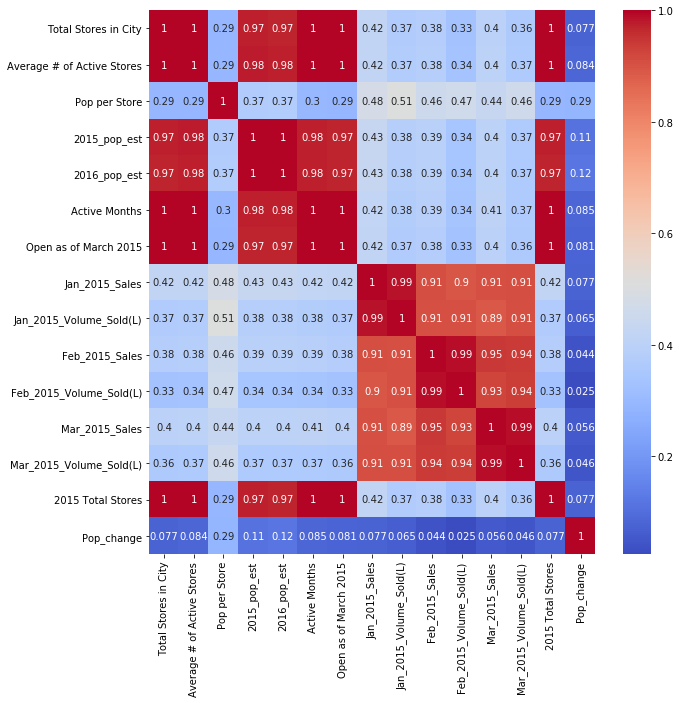

In [1528]:
# Interaction variables.  
# I could just add up the first three months of sales, but temporally that makes little since to me.  They do relate.
sns.heatmap(features.corr(), cmap='coolwarm' , annot=True)
# Uh wow.  Need to address sales/volume.
# I am confused as to why pop per store shows no relation. I think i will avoid it.

In [1529]:
# Interactions for Sales and Volume
features['Sale_interact'] = features['Jan_2015_Sales'] * features['Feb_2015_Sales'] * features['Mar_2015_Sales']
features['Vol_interact'] = features['Jan_2015_Volume_Sold(L)'] + features['Feb_2015_Volume_Sold(L)'] + features['Mar_2015_Volume_Sold(L)']
features['Sale_Vol_interact'] = features['Sale_interact'] * features['Vol_interact']

### Going to bring in college data and see if that helps any

The model on the full dataset is not working nearly as well.  The features I built have needed refining multiple times as either their p-values are too high or they increase my mean squared error.

In [1530]:
colleges = pd.read_csv('/Users/dale/DSI/Datasets/College_data.csv', na_filter=False)

In [1531]:
colleges = colleges[colleges['STABBR']=='IA']

In [1532]:
colleges.columns

Index(['UNITID', 'OPEID', 'OPEID6', 'INSTNM', 'CITY', 'STABBR', 'INSTURL',
       'NPCURL', 'HCM2', 'PREDDEG',
       ...
       'RET_PTL4', 'PCTFLOAN', 'UG25ABV', 'MD_EARN_WNE_P10', 'GT_25K_P6',
       'GRAD_DEBT_MDN_SUPP', 'GRAD_DEBT_MDN10YR_SUPP', 'RPY_3YR_RT_SUPP',
       'C150_L4_POOLED_SUPP', 'C150_4_POOLED_SUPP'],
      dtype='object', length=123)

In [1533]:
#colleges['CCSIZSET'] damn, that's supposed to be size/type
colleges['UGDS'] = colleges['UGDS'].apply(lambda x: 0 if x =='NULL' else x)
colleges['UGDS'] = colleges['UGDS'].astype(int)
colleges[['INSTNM', 'CITY', 'UGDS']].sort_values('UGDS', ascending=False).head()

,INSTNM,CITY,UGDS
4251,Kaplan University-Davenport Campus,Davenport,35040
1232,Iowa State University,Ames,29520
1235,University of Iowa,Iowa City,21970
1208,Des Moines Area Community College,Ankeny,13423
1250,University of Northern Iowa,Cedar Falls,9934


In [1534]:
colleges = colleges.groupby('CITY', as_index=False)['UGDS'].sum()
colleges.columns = ['City', 'Undergrads']
colleges['City'] = colleges['City'].str.upper()

In [1535]:
features = pd.merge(features, colleges, how='left', on='City')

## Let's see about the target

In [1536]:
# Every store's total sales
# BIGMERGE2015.groupby(['City', 'Store Number'], as_index=False)['Sale (Dollars)'].sum().dropna()

In [1537]:
# GRRRRRRRRR changing target to total sales in city; we'll just try it out and see.
# This actually ended up predicting much better.
features = pd.merge(features, BIGMERGE2015.groupby('City', as_index=False)['Sale (Dollars)'].sum(), how='left', on='City')

In [1538]:
citytarget = features[['City', 'Sale (Dollars)', '2015 Total Stores']]

In [1539]:
citytarget['2015 Avg Store Sales'] = citytarget['Sale (Dollars)'] / citytarget['2015 Total Stores']


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [1540]:
citytarget[citytarget['2015 Avg Store Sales'].isnull()]

,City,Sale (Dollars),2015 Total Stores,2015 Avg Store Sales
131,GILBERTVILLE,NaN,1,NaN
288,RUNNELLS,NaN,1,NaN
296,SEYMOUR,NaN,1,NaN
327,TABOR,NaN,1,NaN


In [1541]:
features = features.drop([131,288,296,327])
citytarget = citytarget.drop([131,288,296,327])

citytarget = citytarget.drop(['Sale (Dollars)', '2015 Total Stores'], 1)

In [1542]:
# Test to ensure same shape between target and features
print(features.shape)
print(citytarget.shape)

(367, 21)
(367, 2)


In [1543]:
# Last we do want to fill in any NaNs that were hiding in our sales data
features = features.fillna(0)

In [1544]:
features.head(1)

,City,Total Stores in City,Average # of Active Stores,Pop per Store,2015_pop_est,2016_pop_est,Active Months,Open as of March 2015,Jan_2015_Sales,Jan_2015_Volume_Sold(L),...,Feb_2015_Volume_Sold(L),Mar_2015_Sales,Mar_2015_Volume_Sold(L),2015 Total Stores,Pop_change,Sale_interact,Vol_interact,Sale_Vol_interact,Undergrads,Sale (Dollars)
0,ACKLEY,2.0,2.0,776.0,1552.0,1546.0,24.0,2.0,2662.07,250.185,...,143.5,2047.885,203.16,2,-0.003866,7.958047e+09,596.845,4.749721e+12,0.0,61712.61


In [1545]:
features_model = features.drop(['Open as of March 2015', 'Jan_2015_Volume_Sold(L)', '2015 Total Stores', 'Feb_2015_Volume_Sold(L)', 'Mar_2015_Volume_Sold(L)', 'Vol_interact', 'Sale_Vol_interact', 'City', 'Sale (Dollars)', 'Total Stores in City', 'Average # of Active Stores', 'Pop per Store', '2016_pop_est', 'Active Months'], 1)
# So many features come and go.  I can't even remember them all anymore.

#'Jan_2015_Sales', 'Feb_2015_Sales', 'Mar_2015_Sales', 'Jan_2015_Volume_Sold(L)', 'Feb_2015_Volume_Sold(L)', 'Mar_2015_Volume_Sold(L)'
#'Sale_interact', 'Vol_interact', 'Sale_Vol_interact',

In [1546]:
features_model.head(1)

,2015_pop_est,Jan_2015_Sales,Feb_2015_Sales,Mar_2015_Sales,Pop_change,Sale_interact,Undergrads
0,1552.0,2662.07,1459.76,2047.885,-0.003866,7.958047e+09,0.0


## Break into training and test dataset:

In [1547]:
from sklearn.model_selection import train_test_split

In [1548]:
# Testing variables
X_train, X_test, y_train, y_test = train_test_split(features_model, citytarget.drop('City',1), test_size=0.3, random_state=7)


In [1549]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(256, 7) (256, 1)
(111, 7) (111, 1)


## AND WE BUILD THE MODEL!!!

In [1550]:
# if I want to try Patsy: formula='Lottery ~ Literacy + Wealth + Region', data=df
#train = pd.concat([X_train, y_train], 1)
#train.head()

In [1551]:
X_train = sm.add_constant(X_train) 
model = sm.OLS(y_train, X_train).fit() ## sm.OLS(output, input)
predictions = model.predict(X_train)
model.summary()
# P-value death of many features

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     2015 Avg Store Sales   R-squared:                       0.929
Model:                              OLS   Adj. R-squared:                  0.928
Method:                   Least Squares   F-statistic:                     544.9
Date:                  Sat, 21 Oct 2017   Prob (F-statistic):          4.35e-140
Time:                          13:26:20   Log-Likelihood:                -2980.2
No. Observations:                   256   AIC:                             5974.
Df Residuals:                       249   BIC:                             5999.
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2726.4780   2761.571     -0.987      0.324   -8165.494    2712.538
2015_pop_est      -0.4833      0.278     -1.736      0.084      -1.031       0.065
Jan_2015_Sales     6.7646      0.719      9.408      0.000       5.348       8.181
Feb_2015_Sales     3.2256      0.624      5.172      0.000       1.997       4.454
Mar_2015_Sales     3.0167      0.683      4.418      0.000       1.672       4.362
Pop_change         2.4699      2.502      0.987      0.324      -2.457       7.397
Sale_interact  -5.118e-10   7.03e-11     -7.282      0.000    -6.5e-10   -3.73e-10
Undergrads         1.4814      0.822      1.801      0.073      -0.138       3.101
==============================================================================
Omnibus:                      104.837   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3535.432
Skew:                           0.903   Prob(JB):                         0.00
Kurtosis:                      21.116   Cond. No.                     2.58e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.58e+15. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Mean Squared Error: 651182.407957


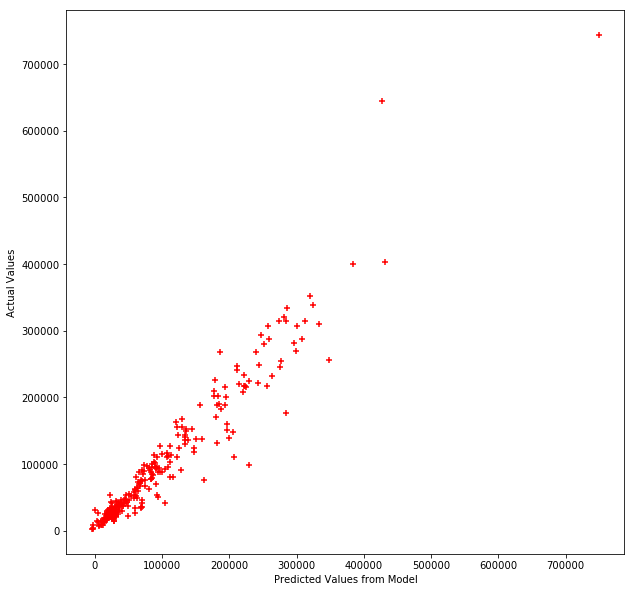

In [1552]:
# And plot the predictions against the actual values
plt.scatter(predictions, y_train, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values from Model")
plt.ylabel("Actual Values")
print("Mean Squared Error:", np.sqrt(model.mse_model))
plt.show()

Alright, let's do some validation to predict how we'll do once we look at more data

In [1553]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
scores = cross_val_score(model, X_train, y_train, cv=10)

In [1554]:
print("Cross-validated scores:", scores)
print("Average: ", scores.mean())

Cross-validated scores: [ 0.82872528  0.95378273  0.95029271  0.88531063  0.88488779  0.27270616
  0.93537318  0.82614659  0.91889193  0.8055238 ]
Average:  0.826164079462


Cross-Predicted Accuracy: 0.74512625879


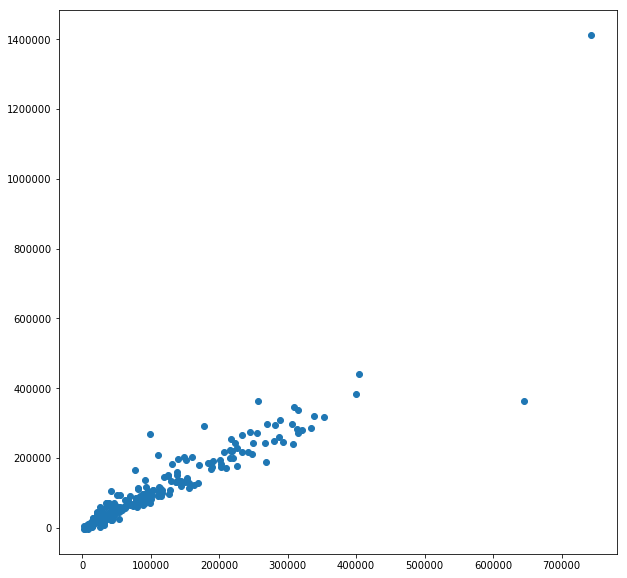

In [1555]:
predictions = cross_val_predict(model, X_train, y_train, cv=10)
plt.scatter(y_train, predictions)
accuracy = metrics.r2_score(y_train, predictions)
print("Cross-Predicted Accuracy:", accuracy)
# I cannot get the more extreme points!  They mess up my accuracy.

I want to double check those regularization results as well.

In [1556]:
lassoregcv = LassoCV(n_alphas=10, normalize=True)
lassoregcv.fit(X_train, y_train.values.ravel())
lassoregcv.alpha_

1314.7553512683878

In [1557]:
lassoreg = Lasso(alpha=1314, normalize=True)
lassoreg.fit(X_train, y_train)
print(lassoreg.coef_)
# Here be the graveyard of many a feature

[ 0.          0.          5.28969683  1.80437597  2.03565499  0.          0.
  0.        ]


In [1558]:
y_pred = lassoreg.predict(X_train)
print(np.sqrt(metrics.mean_squared_error(y_train, y_pred)))
# Again, a much better mean squared error

37288.0967147


In [1559]:
for i, f in enumerate(features_model.columns):
    print(f, lassoregcv.coef_[i+1]) #account for the y intercept

2015_pop_est 0.0
Jan_2015_Sales 5.28912292764
Feb_2015_Sales 1.80391170955
Mar_2015_Sales 2.03527992174
Pop_change 0.0
Sale_interact 0.0
Undergrads 0.0


In [1560]:
# my features always get dropped.  Sooooo depressing every time!
X = X_train.drop(['2015_pop_est', 'Pop_change', 'Undergrads', 'Sale_interact'],1)
y = y_train
X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     2015 Avg Store Sales   R-squared:                       0.913
Model:                              OLS   Adj. R-squared:                  0.912
Method:                   Least Squares   F-statistic:                     881.5
Date:                  Sat, 21 Oct 2017   Prob (F-statistic):          2.90e-133
Time:                          13:26:45   Log-Likelihood:                -3006.6
No. Observations:                   256   AIC:                             6021.
Df Residuals:                       252   BIC:                             6035.
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           5257.7246   2755.261      1.908      0.057    -168.548    1.07e+04
Jan_2015_Sales     6.2936      0.788      7.984      0.000       4.741       7.846
Feb_2015_Sales     2.6133      0.680      3.846      0.000       1.275       3.952
Mar_2015_Sales     2.6825      0.744      3.606      0.000       1.217       4.148
==============================================================================
Omnibus:                      101.480   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3799.416
Skew:                           0.807   Prob(JB):                         0.00
Kurtosis:                      21.804   Cond. No.                     3.07e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1561]:
lm = linear_model.LinearRegression()
model = lm.fit(X, y)
scores = cross_val_score(model, X, y, cv=10)

In [1562]:
print("Cross-validated scores:", scores)
print("Average: ", scores.mean())
# Not seeing any desperately low accuracies here

Cross-validated scores: [ 0.80824397  0.95822036  0.94998603  0.90463305  0.90743499  0.89213398
  0.93587514  0.84077686  0.90407262  0.82574432]
Average:  0.892712132115


Cross-Predicted Accuracy: 0.88628889491
Root Mean Squared Error 34873.6107099


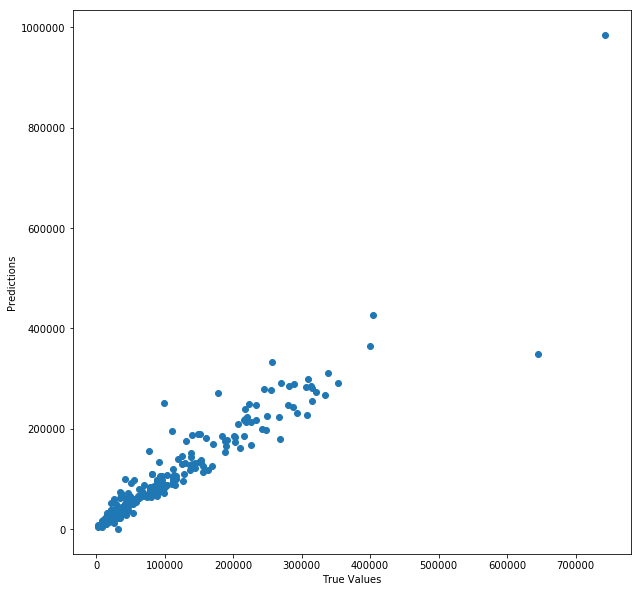

In [1563]:
predictions = cross_val_predict(model, X, y, cv=10)
plt.scatter(y, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
accuracy = metrics.r2_score(y, predictions)
print("Cross-Predicted Accuracy:", accuracy)
print("Root Mean Squared Error", np.sqrt(metrics.mean_squared_error(y, predictions)))
plt.show()
# Pretty clear that there are still a couple of outliers I am unable to account for.

In [1564]:
#y_train['pred'] = predictions
#y_train.sort_values('2015 Avg Store Sales', ascending=False)
#235 #224 look like outliers
#235 Mount Vernon overpredict - new store was openned in 2015
#224 Milford underpredict
features.loc[235]

City                          MOUNT VERNON
Total Stores in City                     3
Average # of Active Stores               2
Pop per Store                       2220.5
2015_pop_est                          4441
2016_pop_est                          4444
Active Months                           24
Open as of March 2015                    2
Jan_2015_Sales                     72569.6
Jan_2015_Volume_Sold(L)            5511.69
Feb_2015_Sales                     87792.8
Feb_2015_Volume_Sold(L)            6160.28
Mar_2015_Sales                     86187.8
Mar_2015_Volume_Sold(L)            6328.13
2015 Total Stores                        3
Pop_change                     0.000675524
Sale_interact                   5.4911e+14
Vol_interact                       18000.1
Sale_Vol_interact              9.88404e+18
Undergrads                            1035
Sale (Dollars)                 2.23125e+06
Name: 235, dtype: object

## Drum roll... now we test!

In [1565]:
X2 = X_test.drop(['2015_pop_est', 'Pop_change', 'Undergrads', 'Sale_interact'], 1)
X2 = sm.add_constant(X2) 

In [1566]:
#retrain on full set
lm = linear_model.LinearRegression()
model = lm.fit(X_train.drop(['2015_pop_est', 'Pop_change', 'Undergrads', 'Sale_interact'], 1), y_train)

Score: 0.942703861027


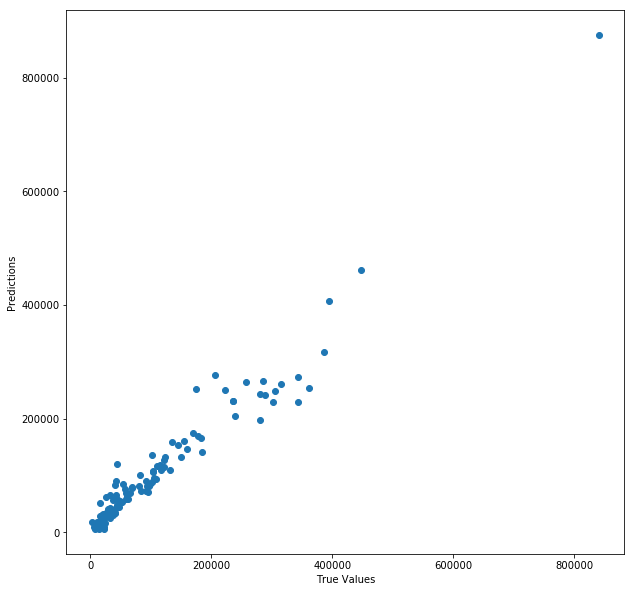

In [1567]:
predictions = lm.predict(X2)
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
print("Score:", model.score(X2, y_test))

In [1568]:
accuracy = metrics.r2_score(y_test, predictions)
print("Cross-Predicted Accuracy:", accuracy)

Cross-Predicted Accuracy: 0.942703861027


In [1569]:
print(np.sqrt(metrics.mean_squared_error(y_test, predictions)))

29546.3546


## $R^2$ of above 90%  and a low Root MSE as well.

# Final Model

In [1623]:
final_X = features_model.drop(['2015_pop_est', 'Pop_change', 'Undergrads', 'Sale_interact'],1)
final_y = citytarget.drop('City',1)
final_X = sm.add_constant(final_X) 
lm = linear_model.LinearRegression()
model = lm.fit(final_X, final_y)
scores = cross_val_score(model, final_X, final_y, cv=10)

In [1624]:
# Let's peak and see how it does with all the data
print("Cross-validated scores:", scores)
print("Average: ", scores.mean())

Cross-validated scores: [ 0.90777981  0.88698813  0.9578912   0.93150597  0.94027609  0.92644063
  0.8398122   0.93906058  0.92539962  0.95739998]
Average:  0.921255421636


Cross-Predicted Accuracy: 0.925311623862
Root Mean Squared Error 30054.501853


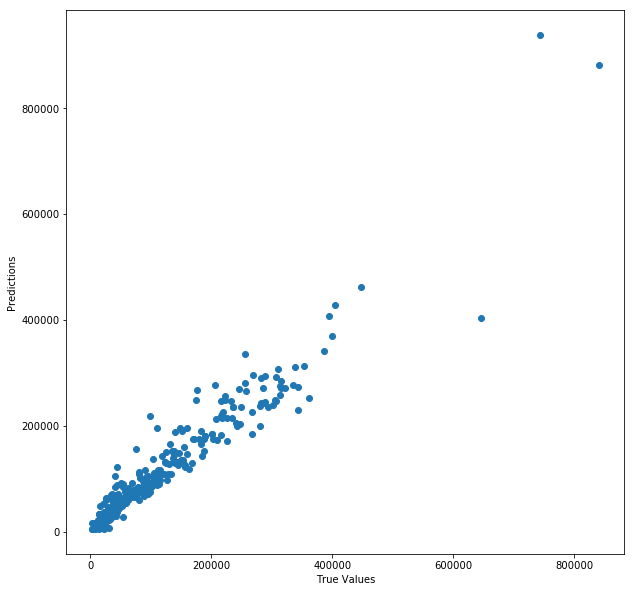

In [1625]:
predictions = model.predict(final_X)
plt.scatter(final_y, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
accuracy = metrics.r2_score(final_y, predictions)
print("Cross-Predicted Accuracy:", accuracy)
print("Root Mean Squared Error", np.sqrt(metrics.mean_squared_error(final_y, predictions)))
plt.show()

In [1589]:
#final_y['pred'] = predictions
#final_y.sort_values('2015 Avg Store Sales', ascending=False)
#235 #224 #365 this time
#235 Mount Vernon overpredict - new store was openned in 2015
#224 Milford underpredict by 200k
#365 Windsor Heights overpredict by 40k
#features.loc[365]

## Let's predict 2016 average store sales by city:

In [1669]:
# Getting 2016 data for the model
BIGMERGE2016 = BIGMERGE[BIGMERGE['Year']==2016]

In [1670]:
# Create features dataframe.
features = BIGMERGE2016.groupby(['City', 'Store Number'], as_index=False)['Total Stores in City', 'Stores with Sales in City', 'Pop per Store', '2015_pop_est', '2016_pop_est'].mean()

In [1671]:
# drop the extra rows as city lists each store number (whether in the city or not)
features = features[features['Total Stores in City'].isnull() != True]

In [1672]:
# This checks to see if sales were made in Feb or Mar 2016 as proxy for being open
# Checks to see if there was a purchase in February 2016
BIGMERGE2016['feb16_sale'] = ((BIGMERGE2016['Month']==2) & (BIGMERGE2016['Sale (Dollars)'].isnull() != True))
# Checks to see if there was a purchase in March 2016
BIGMERGE2016['mar16_sale'] = ((BIGMERGE2016['Month']==3) & (BIGMERGE2016['Sale (Dollars)'].isnull() != True))
# Now we add those columns to the target dataframe
features = pd.merge(features, BIGMERGE2016.groupby(['Store Number'], as_index=False)['feb16_sale', 'mar16_sale'].sum(), how='left', on='Store Number')
# Create a column if they are open on either
features['Open as of March 2016'] = ((features['feb16_sale']==True) | (features['mar16_sale']==True))


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [1673]:
features['Open as of March 2016'].value_counts()


True     1307
False      96
Name: Open as of March 2016, dtype: int64

In [1674]:
# Each stores number of months with sales
features['Active Months'] = BIGMERGE2016.groupby(['City', 'Store Number'], as_index=False)['Sale (Dollars)'].count().dropna().reset_index()['Sale (Dollars)']

In [1676]:
features_store = features.copy()

In [1678]:
# Roll up by cities
# Not sure which I like more, Stores with Sales in City or Active Months.  Active Months summed becomes 'store months in a year'
features = features_store.groupby('City', as_index=False)['Total Stores in City', 'Stores with Sales in City', 'Pop per Store', '2015_pop_est', '2016_pop_est', 'Category Name'].mean()
# Rolled up as city, the Closed should be the difference in total stores and 'stores with sales' and also related to active months
features = pd.merge(features, features_store.groupby('City', as_index=False)['Active Months', 'Open as of March 2016'].sum(), how='left', on='City')

In [1679]:
# Add columns for January 2015 average store sales and volume sold
features = pd.merge(features, BIGMERGE[(BIGMERGE['Year']==2016) & (BIGMERGE['Month']==1)].groupby('City', as_index=False)[['Sale (Dollars)', 'Volume Sold (Liters)']].mean(), how='left', on='City')


In [1680]:
# And February
features = pd.merge(features, BIGMERGE[(BIGMERGE['Year']==2016) & (BIGMERGE['Month']==2)].groupby('City', as_index=False)[['Sale (Dollars)', 'Volume Sold (Liters)']].mean(), how='left', on='City')


In [1681]:
# And March
features = pd.merge(features, BIGMERGE[(BIGMERGE['Year']==2016) & (BIGMERGE['Month']==3)].groupby('City', as_index=False)[['Sale (Dollars)', 'Volume Sold (Liters)']].mean(), how='left', on='City')


In [1682]:
# Total stores in 2015 (prior was total stores period)  I want to use this for my target.
store2015 = BIGMERGE2015.groupby(['Year','Month','City'], as_index=False)['Store Number'].count()
features = pd.merge(features, store2015[store2015['Month']==1], how='left', on='City')
features = features.drop(['Year', 'Month'], 1)

## PAY ATTENTION, YOU'RE RENAMING COLUMNS HERE

In [1684]:
# Rename columns
features.columns = ['City', '2016 Total Stores in City', 'Average # of Active Stores', 'Pop per Store', '2015_pop_est', '2016_pop_est', 'Avg Booze Categories', 'Active Months', 'Open as of March 2016', 'Jan_2016_Sales', 'Jan_2016_Volume_Sold(L)', 'Feb_2016_Sales', 'Feb_2016_Volume_Sold(L)', 'Mar_2016_Sales', 'Mar_2016_Volume_Sold(L)', '2015 Total Stores']

In [1685]:
features.head()

,City,2016 Total Stores in City,Average # of Active Stores,Pop per Store,2015_pop_est,2016_pop_est,Avg Booze Categories,Active Months,Open as of March 2016,Jan_2016_Sales,Jan_2016_Volume_Sold(L),Feb_2016_Sales,Feb_2016_Volume_Sold(L),Mar_2016_Sales,Mar_2016_Volume_Sold(L),2015 Total Stores
0,ACKLEY,2.0,2.000000,776.000000,1552.0,1546.0,503.500000,6.0,2.0,3075.710,240.375000,4302.69,325.070000,2557.235000,207.920000,2
1,ADAIR,2.0,1.333333,605.833333,727.0,716.0,189.500000,4.0,1.0,1457.525,89.180000,3597.60,239.250000,2867.580000,213.000000,2
2,ADEL,3.0,3.000000,1331.666667,3995.0,4293.0,958.333333,9.0,3.0,6190.100,561.103333,5601.28,488.896667,10738.973333,822.146667,3
3,AFTON,1.0,1.000000,828.000000,828.0,832.0,175.000000,3.0,1.0,3378.100,286.800000,895.38,69.000000,2696.880000,231.000000,1
4,AKRON,1.0,1.000000,1454.000000,1454.0,1465.0,669.000000,3.0,1.0,1678.980,133.650000,4305.39,330.880000,2512.390000,231.270000,1


In [1686]:
# Prejected population change from 2015 to 2016
features['Pop_change_to_2016'] = (features['2016_pop_est'] - features['2015_pop_est']) / features['2015_pop_est']

### Going to bring in college data for recommendations

In [1687]:
features = pd.merge(features, colleges, how='left', on='City')

USE THIS TO ADD CLOSED STORES

In [1688]:
# Will use full dataset to count number of closed stores by city.
# Checks to see if there was a purchase in February 2016
BIGMERGE['feb16_sale'] = ((BIGMERGE['Month']==2) & (BIGMERGE['Year']==2016) & (BIGMERGE['Sale (Dollars)'].isnull() != True))
# Checks to see if there was a purchase in March 2016
BIGMERGE['mar16_sale'] = ((BIGMERGE['Month']==3) & (BIGMERGE['Year']==2016) & (BIGMERGE['Sale (Dollars)'].isnull() != True))

prep_merge = BIGMERGE[['City', 'Store Number','feb16_sale', 'mar16_sale']].groupby(['City','Store Number'],as_index=False)['feb16_sale', 'mar16_sale'].sum().dropna()#, how='left', on='Store Number')
prep_merge['Stores to close since Jan 2015'] = ((prep_merge['feb16_sale']!=True) & (prep_merge['mar16_sale']!=True))
features = pd.merge(features, prep_merge.groupby('City', as_index=False)['Stores to close since Jan 2015'].sum(), how='left', on='City')

In [1690]:
features.head()

,City,2016 Total Stores in City,Average # of Active Stores,Pop per Store,2015_pop_est,2016_pop_est,Avg Booze Categories,Active Months,Open as of March 2016,Jan_2016_Sales,Jan_2016_Volume_Sold(L),Feb_2016_Sales,Feb_2016_Volume_Sold(L),Mar_2016_Sales,Mar_2016_Volume_Sold(L),2015 Total Stores,Pop_change_to_2016,Undergrads,Stores to close since Jan 2015
0,ACKLEY,2.0,2.000000,776.000000,1552.0,1546.0,503.500000,6.0,2.0,3075.710,240.375000,4302.69,325.070000,2557.235000,207.920000,2,-0.003866,NaN,0.0
1,ADAIR,2.0,1.333333,605.833333,727.0,716.0,189.500000,4.0,1.0,1457.525,89.180000,3597.60,239.250000,2867.580000,213.000000,2,-0.015131,NaN,1.0
2,ADEL,3.0,3.000000,1331.666667,3995.0,4293.0,958.333333,9.0,3.0,6190.100,561.103333,5601.28,488.896667,10738.973333,822.146667,3,0.074593,NaN,0.0
3,AFTON,1.0,1.000000,828.000000,828.0,832.0,175.000000,3.0,1.0,3378.100,286.800000,895.38,69.000000,2696.880000,231.000000,1,0.004831,NaN,0.0
4,AKRON,1.0,1.000000,1454.000000,1454.0,1465.0,669.000000,3.0,1.0,1678.980,133.650000,4305.39,330.880000,2512.390000,231.270000,1,0.007565,NaN,0.0


# Now to actually predict

In [1691]:
features_2016 = features[['Jan_2016_Sales', 'Feb_2016_Sales', 'Mar_2016_Sales']]
features_2016 = features_2016.fillna(0)
features_2016 = sm.add_constant(features_2016) 

In [1692]:
predictions = model.predict(features_2016)

In [1693]:
features['Store_Avg_2016_Total_Est'] = predictions

In [1753]:
features['New_Store_2016_Projection'] = (features['Store_Avg_2016_Total_Est']*features['Open as of March 2016'])/(features['Open as of March 2016']+1)

In [1792]:
features.sort_values('New_Store_2016_Projection', ascending=False).head(10)#.to_csv('top_10.csv')

,City,2016 Total Stores in City,Average # of Active Stores,Pop per Store,2015_pop_est,2016_pop_est,Avg Booze Categories,Active Months,Open as of March 2016,Jan_2016_Sales,...,Feb_2016_Sales,Feb_2016_Volume_Sold(L),Mar_2016_Sales,Mar_2016_Volume_Sold(L),2015 Total Stores,Pop_change_to_2016,Undergrads,Stores to close since Jan 2015,Store_Avg_2016_Total_Est,New_Store_2016_Projection
235,MOUNT VERNON,3.0,2.000000,2220.500000,4441.0,4444.0,4030.000000,6.0,2.0,90401.125000,...,104651.935000,7606.865000,124654.775000,8703.335000,3,0.000676,1035.0,1.0,1.186054e+06,790702.635618
365,WINDSOR HEIGHTS,6.0,6.000000,835.500000,5013.0,4983.0,4613.166667,18.0,6.0,54035.460000,...,48695.423333,3887.661667,54804.580000,3799.925000,6,-0.005984,NaN,0.0,6.219661e+05,533113.759559
89,DES MOINES,90.0,76.000000,2826.826291,214814.0,215472.0,2653.088889,228.0,76.0,31558.350649,...,41709.924533,2535.548533,43987.645526,2665.629079,90,0.003063,6605.0,14.0,4.366040e+05,430933.805078
30,BETTENDORF,12.0,10.666667,3335.412121,35506.0,35727.0,3065.500000,32.0,11.0,34331.174545,...,43287.087000,2730.152000,40605.620909,2453.476364,12,0.006224,261.0,1.0,4.523086e+05,414616.185820
224,MILFORD,2.0,1.666667,2011.333333,3017.0,3055.0,4580.500000,5.0,2.0,40458.080000,...,63612.480000,4316.700000,33475.425000,2450.100000,2,0.012595,NaN,0.0,5.468507e+05,364567.114871
68,CORALVILLE,14.0,11.333333,1787.121212,20220.0,20397.0,2581.285714,34.0,11.0,29020.878333,...,35136.128182,2167.967273,42339.270000,2376.471818,14,0.008754,NaN,3.0,3.944863e+05,361612.456787
170,IOWA CITY,26.0,24.333333,3017.432222,73397.0,74398.0,3090.615385,73.0,25.0,26914.127200,...,35639.885000,2495.040000,36517.757500,2289.906250,26,0.013638,22068.0,1.0,3.713193e+05,357037.788768
11,AMES,25.0,23.333333,2808.444444,65504.0,66191.0,3035.720000,70.0,25.0,23724.738750,...,28551.710000,2164.750435,26794.310870,1797.611304,25,0.010488,29630.0,0.0,3.068105e+05,295010.104112
79,DAVENPORT,45.0,42.333333,2424.109265,102608.0,102612.0,2592.911111,127.0,44.0,21756.509762,...,25690.399535,1806.406512,30600.004762,1959.595000,45,0.000039,41561.0,1.0,2.924284e+05,285930.000223
178,KEOKUK,7.0,6.666667,1595.849206,10583.0,10431.0,2438.285714,20.0,7.0,25026.028333,...,32017.970000,2110.891429,24128.490000,1740.255714,7,-0.014363,NaN,0.0,3.215413e+05,281348.604900


## Excellent.  What follows is workspace for research into top picks and make some graphs to show important relationships to keep in mind when openning a new store.

In [1832]:
# So far in 2016 (Jan through Mar)
BIGMERGE2016[BIGMERGE2016['City']=='IOWA CITY'].groupby('Store Number', as_index=False)[['Sale (Dollars)', 'Volume Sold (Liters)']].sum().dropna().sort_values('Sale (Dollars)',ascending=False)

,Store Number,Sale (Dollars),Volume Sold (Liters)
1,2512,1050711.75,70102.40
8,3926,226204.99,17875.82
4,2622,171119.44,10901.02
0,2285,158700.11,7240.32
2,2513,149791.31,10520.09
9,3980,115110.42,8665.50
3,2545,102829.30,6689.98
15,4697,83064.58,3755.30
7,3896,43366.77,2447.75
6,3565,38515.52,2834.88


In [1829]:
BIGMERGE[BIGMERGE['City']=='IOWA CITY'].groupby(['Store Number'], as_index=False).agg({'Sale (Dollars)':['sum'], 'Varieties of Alcohol':['mean']}).sort_values(('Sale (Dollars)', 'sum'),ascending=False).head(25)

,Store Number,Sale (Dollars),Varieties of Alcohol
,,sum,mean
1,2512,5206377.22,1314
8,3926,1108208.76,644
0,2285,936251.76,679
4,2622,921132.64,859
2,2513,800558.95,666
9,3980,684154.28,382
3,2545,618449.87,842
15,4697,453902.38,327
14,4481,440770.89,502


In [1828]:
# Look at store data in detail for 2016
BIGMERGE2016[BIGMERGE2016['City']=='IOWA CITY'].head(10)

,Year,Month,Store Number,Bottle Volume (ml),Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),City,State Bottle Cost,...,2010_pop,2015_pop_est,2016_pop_est,Total Stores in City,Stores with Sales in City,Pop per Store,feb16_sale,mar16_sale,Category Name_x,Category Name_y
13,2016,1,2285,132353.0,2169.0,46194.08,1860.60,491.70,IOWA CITY,17.416358,...,67862.0,73397.0,74398.0,26,25.0,2935.88,False,False,3581,3581
36,2016,1,2512,898150.0,20658.0,282756.31,19207.70,5074.51,IOWA CITY,10.965561,...,67862.0,73397.0,74398.0,26,25.0,2935.88,False,False,17962,17962
37,2016,1,2513,430900.0,3515.0,45268.02,3221.35,850.93,IOWA CITY,9.282521,...,67862.0,73397.0,74398.0,26,25.0,2935.88,False,False,8608,8608
56,2016,1,2545,377575.0,1984.0,25590.50,1705.24,450.43,IOWA CITY,9.969725,...,67862.0,73397.0,74398.0,26,25.0,2935.88,False,False,8776,8776
116,2016,1,2622,408875.0,3596.0,54812.30,3326.46,878.72,IOWA CITY,11.213220,...,67862.0,73397.0,74398.0,26,25.0,2935.88,False,False,7069,7069
165,2016,1,2844,71000.0,528.0,5824.06,606.00,160.08,IOWA CITY,8.474107,...,67862.0,73397.0,74398.0,26,25.0,2935.88,False,False,975,975
225,2016,1,3565,137125.0,704.0,8944.53,674.60,178.18,IOWA CITY,9.129937,...,67862.0,73397.0,74398.0,26,25.0,2935.88,False,False,3292,3292
365,2016,1,3896,67075.0,2088.0,11140.34,729.54,192.94,IOWA CITY,5.612000,...,67862.0,73397.0,74398.0,26,25.0,2935.88,False,False,3733,3733
378,2016,1,3926,342925.0,5310.0,61554.78,5124.29,1353.84,IOWA CITY,9.582608,...,67862.0,73397.0,74398.0,26,25.0,2935.88,False,False,6480,6480
399,2016,1,3980,254000.0,2376.0,33665.76,2496.00,659.46,IOWA CITY,10.058273,...,67862.0,73397.0,74398.0,26,25.0,2935.88,False,False,4388,4388


In [1833]:
# Get address and name of specific stores for research
# Note: have to reset the bigboy as those columns were dropped
#bigboy = pd.read_csv('/Users/dale/DSI/Datasets/Iowa/iowa_liquor_sales_proj_2.csv', na_filter=False)
bigboy[bigboy['Store Number']==3926].head(1)

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,...,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
313,S23877600066,02/04/2015,3926,Liquor Downtown / Iowa City,315 S GILBERT ST,IOWA CITY,52240,"315 S GILBERT ST\nIOWA CITY 52240\n(41.657654,...",52,Johnson,...,34006,Absolut Swedish Vodka 80 Prf,12,750,$11.49,$17.24,12,$206.88,9.0,2.38


In [1824]:
# Top 25 stores by sales overall
BIGMERGE.groupby(['City','Store Number'], as_index=False).agg({'Sale (Dollars)':['sum'], 'Varieties of Alcohol':['mean']}).sort_values(('Sale (Dollars)', 'sum'),ascending=False).head(25)

,City,Store Number,Sale (Dollars),Varieties of Alcohol
,,,sum,mean
478,DES MOINES,2633,12282646.26,1065
538,DES MOINES,4829,11085530.53,905
767,IOWA CITY,2512,5206377.22,1314
207,CEDAR RAPIDS,3385,4759187.79,344
1388,WINDSOR HEIGHTS,3420,4018414.55,213
116,BETTENDORF,3952,3768333.09,629
1353,WEST DES MOINES,3814,3365204.04,102
336,CORALVILLE,2670,3015679.96,1213
212,CEDAR RAPIDS,3773,2948596.43,1105


### Looking at number of different types of alcohol to compare with sales.

In [1740]:
bigboy['Item Description'].nunique()

3029

In [1739]:
bigboy.columns

Index(['Invoice/Item Number', 'Date', 'Store Number', 'Store Name', 'Address',
       'City', 'Zip Code', 'Store Location', 'County Number', 'County',
       'Category', 'Category Name', 'Vendor Number', 'Vendor Name',
       'Item Number', 'Item Description', 'Pack', 'Bottle Volume (ml)',
       'State Bottle Cost', 'State Bottle Retail', 'Bottles Sold',
       'Sale (Dollars)', 'Volume Sold (Liters)', 'Volume Sold (Gallons)'],
      dtype='object')

In [1807]:
# Want to add number of categories of booze for later recommendations
variety_store = pd.merge(BIGMERGE[BIGMERGE['Year']==2015].groupby('Store Number', as_index=False)['Sale (Dollars)'].sum(), bigboy.groupby(['Store Number', 'Item Description'], as_index=False)['Sale (Dollars)'].count().dropna().groupby('Store Number', as_index=False)['Item Description'].count(), how='left', on='Store Number')

In [1808]:
variety_store.columns = ['Store Number', '2015 Total Store Sales', 'Variety of Alcohol']

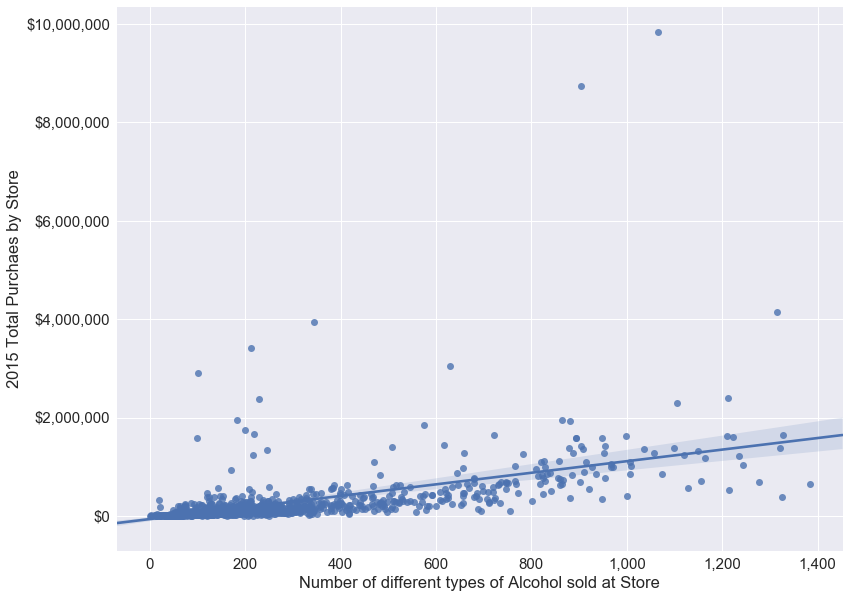

In [1839]:
plt.rcParams['figure.figsize'] = [13, 10]
fig, ax = plt.subplots()
ax = sns.regplot(x=variety_store["Variety of Alcohol"], y=variety_store["2015 Total Store Sales"])
#plt.title('As the types of alcohol sold increase, so do sales')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.ylabel('2015 Total Purchaes by Store')
plt.xlabel('Number of different types of Alcohol sold at Store')
#sns.set(font_scale=1.5) 
fig.savefig('/Users/Dale/Desktop/Alc_Var.svg', format='svg', dpi=2000)
plt.show()


Want to see the how purchases change by store over time.  Ended up using tableau to visualize this.

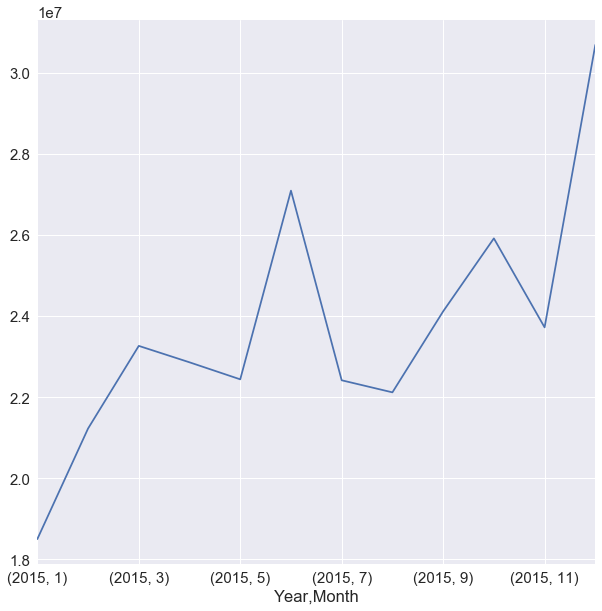

In [1751]:
# multiple line plot
#for city in BIGMERGE2015['City']:
BIGMERGE2015.groupby(('Year', 'Month'))['Sale (Dollars)'].sum().plot()
plt.show()


In [1752]:
#BIGMERGE2015.to_csv('iowa_2015_edit.csv') # for tableau

Looking into average price per bottle in comparison with overall sales

In [1771]:
tot_bot = bigboy[bigboy['Year']==2015].groupby('Store Number', as_index=False)['Bottles Sold'].count()
tot_bot.columns = ['Store Number', '2015 Total Bottles']
# SHOULDN'T MERGE ON ALL; I created duplicates
bigboy = pd.merge(bigboy, tot_bot, how='left', on='Store Number')

In [1772]:
bigboy['Bottles of Total 2015'] = bigboy['Bottles Sold'] / bigboy['2015 Total Bottles']

In [1774]:
bigboy['Average Bottle Price'] = bigboy['State Bottle Retail'] * bigboy['Bottles of Total 2015']

In [1779]:
avg_bottle_price = pd.merge(BIGMERGE2015.groupby('Store Number', as_index=False)['Sale (Dollars)'].sum(), bigboy[bigboy['Year']==2015].groupby('Store Number', as_index=False)['Average Bottle Price', 'Bottles Sold'].sum(), how='left', on='Store Number')
avg_bottle_price['test'] = avg_bottle_price['Bottles Sold'] * avg_bottle_price['Average Bottle Price']

In [1784]:
# Much easier
avg_bottle_price['test2'] = avg_bottle_price['Sale (Dollars)'] / avg_bottle_price['Bottles Sold']
avg_bottle_price = avg_bottle_price.drop(['Average Bottle Price', 'test'], 1)
avg_bottle_price.columns = ['Store Number', 'Sale (Dollars)', 'Bottles Sold', 'Average Bottle Price']

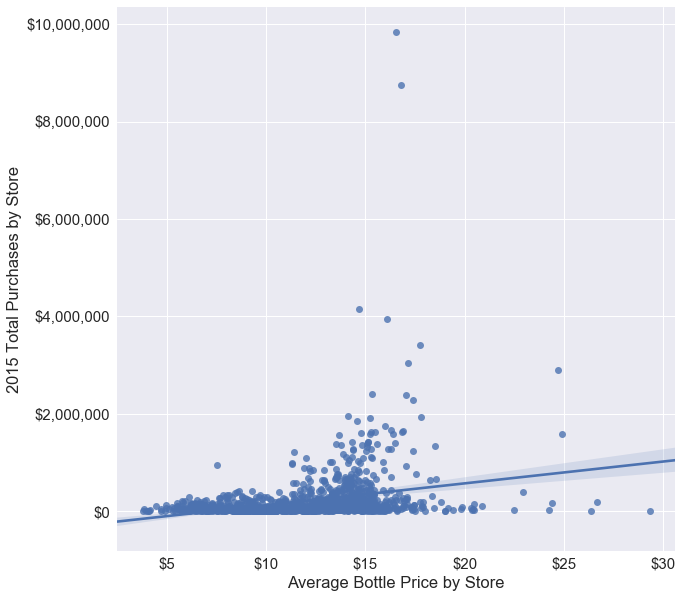

In [1813]:
ax = sns.regplot(x=avg_bottle_price['Average Bottle Price'], y=avg_bottle_price["Sale (Dollars)"])
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))
plt.ylabel('2015 Total Purchases by Store')
plt.xlabel('Average Bottle Price by Store')
#sns.set(font_scale=1.5) 
plt.show()

$$\frac{\text{Total Purchases in City}}{\text{Current Number of Stores}+\text{New Store}}$$